This notebook replicates the tables and figures from the report *Replication of Dickens (2022) “Understanding Ethnolinguistic Differences: The Roles of Geography and Trade"*.

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from scipy.stats import zscore
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys, os, time
pd.set_option('display.width', 140)

# for regex commands
import re

# Geo
from shapely.geometry import Polygon, Point
import geopandas as gp
import geopandas.tools as gpt
gpd = gp

from pyproj import CRS
cea = CRS("ESRI:54034")
wgs84 = CRS("EPSG:4326")

# Mapping
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

from IPython.display import display, HTML, Image, IFrame

# Set paths
# pathgraphs = '/work/graphs/'
# pathdata = '/work/data/'
# shapefile_path = pathdata + 'shapefiles/'

# Do not use these lines in DEEPNOTE
pathgraphs = '../graphs/'
pathdata = '../data/'
shapefile_path = pathdata + '/shapefiles/'

The following code blocks contain the user-defined functions to create the HTML tables (`html_table1` and `html_table2`) or LaTeX tables (`latex_table_1` and `latex_table2`), format the correlation matrices `myheatmap`, and select the samples to run regressions with `mysample`.

In [2]:
# User defined regressions

# Sample
def mysample(myvars, df, FE=True, dummy_cols=['cell_ISO3'],
             cluster_cols = ['cell_ISO3'], zscores=True):
    '''
    Create sample dataframe based on variables
    First variable is dependent variable
    It adds dummies for FE
    Adds cluster variables
    '''
    if len(myvars)<2:
        print('A regression needs at least one dependent and one independent variable!')
        pass
    else:
        k = 0
        for v in myvars:
            if k==0:
                mydf = (df[v].isnull()==False).astype(int)
                k += 1
            else:
                mydf *= (df[v].isnull()==False).astype(int)
        mydf = df.loc[mydf==1].reset_index(drop=True).copy()
        if zscores:
            mydf[myvars] = mydf[myvars].apply(zscore)
        myeq = myvars[0] + ' ~ ' + " + ".join(myvars[1:])
        if FE:
            dummies = pd.get_dummies(mydf[dummy_cols], prefix='_I', prefix_sep='_')
            dummies = dummies.T.groupby(level=0).sum().T
            dummy_columns = " + ".join(dummies.columns)
            myeq += ' + ' + dummy_columns
            mydf = mydf.merge(dummies, left_index=True, right_index=True).copy()
        clustercols = []
        for v in cluster_cols:
            mydf['cluster_'+v] = mydf[v].astype('category').cat.codes
            clustercols.append('cluster_'+v)
        return [mydf, myeq, clustercols]

def myheatmap(df,varx,vary, x_var_names, y_var_names, xtitle, ytitle, gname, label_rotation = 20, top_flip = False, pad_labels = (-.28, -.38), show = False):
    """
    Create a heatmap to illustrate how correlated two sets of variables (var1 and var2)

    INPUTS: 
    df = pandas Dataframe
    varx = list of variables names contained in the dataframe (plotted in the x_axis)
    vary = list of variables names contained in the dataframe (plotted in the y_axis)
    gname = string with the name of the output plot
    show = boolean to show the plot in the notebook (True) or not (False)
    """
    dfheat = df[varx + vary].corr()
    dfheat = dfheat.loc[varx,vary]
    if top_flip:
        dfheat = np.flip(dfheat.values, axis=0)
    fig, ax = plt.subplots(figsize=(15,10), facecolor='w', edgecolor='w')
    sns.heatmap(dfheat, cmap=sns.cm.rocket_r, xticklabels=True, yticklabels=True, cbar=False, vmin=0, vmax=1,
                annot=True, fmt=".2f", linewidth=.5, annot_kws={"size":28}, ax = ax)

    ax.set_xticklabels(x_var_names, fontdict={'size':24})
    if top_flip:
        ax.set_yticklabels(reversed(y_var_names), fontdict={'size':24})
    else:
        ax.set_yticklabels(y_var_names, fontdict={'size':24})

    ax.tick_params(left=True, bottom=True,pad = 10)

    # Set axis labels
    ax.set_xlabel(xtitle, fontdict={'size':32})
    ax.set_ylabel(ytitle, fontdict={'size':32})

    # Add padding between ticks and axis labels
    ax.xaxis.set_label_coords(.5, pad_labels[0])
    ax.yaxis.set_label_coords(pad_labels[1], 0.5)
    
    # xtick on top
    if top_flip:
        ax.xaxis.tick_top()

    # Rotate the ticks
    if top_flip:
        plt.setp(ax.get_xticklabels(), rotation=-1 * label_rotation, ha="right",
         rotation_mode="anchor")
        plt.setp(ax.get_yticklabels(), rotation=-1 * label_rotation, ha="right",
         rotation_mode="anchor")
    else:
        plt.setp(ax.get_yticklabels(), rotation=label_rotation, ha="right",
         rotation_mode="anchor")
        plt.setp(ax.get_xticklabels(), rotation=label_rotation, ha="right",
         rotation_mode="anchor")
    
    

    plt.savefig( pathgraphs + gname + '.pdf', dpi=300, bbox_inches='tight')
    if show == False:
        plt.close()

In [3]:
def html_table_1(name):
    """
    
    INPUTS: 
    name = string with the name of the output table in .html
    """
    
    start = r"""<table>
<thead>
<tr class="header">
<th style="text-align: left;"></th>
<th colspan="6" style="text-align: center;">Dependent variable:
Lexicostatistical linguistic distance <span
class="math inline">∈(0,1)</span></th>
<th style="text-align: center;"></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td style="text-align: left;"><span></span></td>
<td style="text-align: center;">(1)</td>
<td style="text-align: center;">(2)</td>
<td style="text-align: center;">(3)</td>
<td style="text-align: center;">(4)</td>
<td style="text-align: center;">(5)</td>
<td style="text-align: center;">(6)</td>
</tr>
"""
    post_land_prod_var_change = r"""<tr class="even">
<td style="text-align: left;"><span
class="math inline"><em>Δ</em></span> in std CSI in buffer
(post-1500)</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
</tr>""".format(est1_b['csi_change_sd'],est2_b['csi_change_sd'],est3_b['csi_change_sd'],est4_b['csi_change_sd'],est5_b['csi_change_sd'],est6_b['csi_change_sd'],
               est1_se['csi_change_sd'],est2_se['csi_change_sd'],est3_se['csi_change_sd'],est4_se['csi_change_sd'],est5_se['csi_change_sd'],est6_se['csi_change_sd'],
               est1_p['csi_change_sd'],est2_p['csi_change_sd'],est3_p['csi_change_sd'],est4_p['csi_change_sd'],est5_p['csi_change_sd'],est6_p['csi_change_sd'])
    pre_land_prod_var = r"""<tr class="odd">
<td style="text-align: left;">std CSI in buffer
(pre-1500)</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
</tr>""".format(est1_b['csi_sd'],est2_b['csi_sd'],est3_b['csi_sd'],est4_b['csi_sd'],est5_b['csi_sd'],est6_b['csi_sd'],
               est1_se['csi_sd'],est2_se['csi_sd'],est3_se['csi_sd'],est4_se['csi_sd'],est5_se['csi_sd'],est6_se['csi_sd'],
               est1_p['csi_sd'],est2_p['csi_sd'],est3_p['csi_sd'],est4_p['csi_sd'],est5_p['csi_sd'],est6_p['csi_sd'])    
    post_land_prod_change = r"""<tr class="even">
<td style="text-align: left;"><span
class="math inline"><em>Δ</em></span> in average CSI in buffer
(post-1500)</td>
<td style="text-align: center;"></td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
</tr>""".format(est2_b['csi_change'],est3_b['csi_change'],est4_b['csi_change'],est5_b['csi_change'],est6_b['csi_change'],
               est2_se['csi_change'],est3_se['csi_change'],est4_se['csi_change'],est5_se['csi_change'],est6_se['csi_change'],
               est2_p['csi_change'],est3_p['csi_change'],est4_p['csi_change'],est5_p['csi_change'],est6_p['csi_change'])    
    pre_land_prod = r"""<tr class="odd">
<td style="text-align: left;">Average CSI in buffer (pre-1500)</td>
<td style="text-align: center;"></td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
</tr>""".format(est2_b['csi'],est3_b['csi'],est4_b['csi'],est5_b['csi'],est6_b['csi'],
               est2_se['csi'],est3_se['csi'],est4_se['csi'],est5_se['csi'],est6_se['csi'],
               est2_p['csi'],est3_p['csi'],est4_p['csi'],est5_p['csi'],est6_p['csi'])
    FE_rows = r"""<tr class="even">
<td style="text-align: left;">Geography controls</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
</tr>
<tr class="odd">
<td style="text-align: left;">Spatial controls</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
</tr>
<tr class="even">
<td style="text-align: left;">Language family FEs</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
</tr>
<tr class="odd">
<td style="text-align: left;">Country FEs</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">No</td>
<td style="text-align: center;">Yes</td>
</tr>"""
    
    R2_obs = r"""<tr class="even">
<td style="text-align: left;">Adjusted <span
class="math inline"><em>R</em><sup>2</sup></span></td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="odd">
<td style="text-align: left;">Observations</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
</tr>""".format(ad_R1,ad_R2,ad_R3,ad_R4,ad_R5,ad_R6,
               N1,N2,N3,N4,N5,N6)
    end = r"""</tbody>
</table>
<p> Notes: Unit of observation: border buffer zone (100 km). This table establishes the negative and statistically significant effect of variation in land productivity on a language pair`s lexicostatistical linguistic distance. Geography controls include mean elevation, ruggedness, mean temperature and its standard deviation, mean precipitation and its standard deviation, and the prevalence of malaria. Spatial controls include logged distance to the nearest coast, country border, lake, major river and minor river, logged distance between group centroids, the absolute difference in latitude and longitude, logged land area and logged population. SEs are double clustered at the level of each language group and are reported in parentheses.</p>"""
    with open(pathgraphs + name + '.html', 'w') as file:
        file.write(start)
        file.write(post_land_prod_var_change)
        file.write(pre_land_prod_var)
        file.write(post_land_prod_change)
        file.write(pre_land_prod) 
        file.write(FE_rows)
        file.write(R2_obs)
        file.write(end)

In [4]:
def html_table_2(name):
    """

    INPUTS: 
    name = string with the name of the output table in .tex
    """
    
    start = r"""<table>
<thead>
<tr class="header">
<th style="text-align: left;"></th>
<th colspan="7" style="text-align: center;">Dependent variable:
Lexicostatistical linguistic distance <span
class="math inline"> ∈ (0,1)</span></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td style="text-align: left;"></td>
<td colspan="5" style="text-align: center;">Replication</td>
<td colspan="2" style="text-align: center;">Robustness</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td colspan="3" style="text-align: center;">Original Data</td>
<td colspan="2" style="text-align: center;">Reconstructed Data</td>
<td colspan="2" style="text-align: center;">Alternative Measure</td>
</tr>
<tr class="odd">
<td
style="text-align: left;"></td>
<td style="text-align: center;">Original Sample</td>
<td style="text-align: center;">v16</td>
<td style="text-align: center;">v17</td>
<td style="text-align: center;">v16</td>
<td style="text-align: center;">v17</td>
<td style="text-align: center;">v16</td>
<td style="text-align: center;">v17</td>
</tr>
<tr class="even">
<td
style="text-align: left;"></td>
<td style="text-align: center;">(1)</td>
<td style="text-align: center;">(2)</td>
<td style="text-align: center;">(3)</td>
<td style="text-align: center;">(4)</td>
<td style="text-align: center;">(5)</td>
<td style="text-align: center;">(6)</td>
<td style="text-align: center;">(7)</td>
</tr>"""
    post_land_prod_var_change = r"""<tr class="odd">
<td style="text-align: left;"><span
class="math inline"><em>Δ</em></span> in std CSI in buffer
(post-1500)</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
</tr>""".format(est1_b['csi_change_sd'],est2_b['csi_change_sd'],est3_b['csi_change_sd'],est4_b['csi_change_sd_oj'],est5_b['csi_change_sd_oj'],
               est1_se['csi_change_sd'],est2_se['csi_change_sd'],est3_se['csi_change_sd'],est4_se['csi_change_sd_oj'],est5_se['csi_change_sd_oj'],
               est1_p['csi_change_sd'],est2_p['csi_change_sd'],est3_p['csi_change_sd'],est4_p['csi_change_sd_oj'],est5_p['csi_change_sd_oj'])
    
    pre_land_prod_var = r"""<tr class="even">
<td style="text-align: left;">Std CSI in buffer
(pre-1500)</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
</tr>""".format(est1_b['csi_sd'],est2_b['csi_sd'],est3_b['csi_sd'],est4_b['csi_sd_oj'],est5_b['csi_sd_oj'],
               est1_se['csi_sd'],est2_se['csi_sd'],est3_se['csi_sd'],est4_se['csi_sd_oj'],est5_se['csi_sd_oj'],
               est1_p['csi_sd'],est2_p['csi_sd'],est3_p['csi_sd'],est4_p['csi_sd_oj'],est5_p['csi_sd_oj'])
    
    post_land_prod_change = r"""<tr class="odd">
<td style="text-align: left;"><span
class="math inline"><em>Δ</em></span> in average CSI in buffer
(post-1500)</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
</tr>""".format(est1_b['csi_change'],est2_b['csi_change'],est3_b['csi_change'],est4_b['csi_change_oj'],est5_b['csi_change_oj'],est6_b['csi_change'],est7_b['csi_change'],
               est1_se['csi_change'],est2_se['csi_change'],est3_se['csi_change'],est4_se['csi_change_oj'],est5_se['csi_change_oj'],est6_se['csi_change'],est7_se['csi_change'],
               est1_p['csi_change'],est2_p['csi_change'],est3_p['csi_change'],est4_p['csi_change_oj'],est5_p['csi_change_oj'],est6_p['csi_change'],est7_p['csi_change'])
    
    pre_land_prod = r"""<tr class="even">
<td style="text-align: left;">Average CSI in buffer (pre-1500)</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
</tr>""".format(est1_b['csi'],est2_b['csi'],est3_b['csi'],est4_b['csi_oj'],est5_b['csi_oj'],est6_b['csi'],est7_b['csi'],
           est1_se['csi'],est2_se['csi'],est3_se['csi'],est4_se['csi_oj'],est5_se['csi_oj'],est6_se['csi'],est7_se['csi'],
           est1_p['csi'],est2_p['csi'],est3_p['csi'],est4_p['csi_oj'],est5_p['csi_oj'],est6_p['csi'],est7_p['csi'])
    
    cross_border = r"""<tr class="odd">
<td style="text-align: left;"><span
class="math inline"><em>Δ</em></span> in cross border CSI difference
(post-1500)</td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
</tr>""".format(est6_b['csi_change_alt'],est7_b['csi_change_alt'],
           est6_se['csi_change_alt'],est7_se['csi_change_alt'],
           est6_p['csi_change_alt'],est7_p['csi_change_alt'])
    
    cross_border2 = r"""<tr class="even">
<td style="text-align: left;">Cross border CSI difference
(pre-1500)</td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="odd">
<td style="text-align: left;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">({:.3f})</td>
<td style="text-align: center;">({:.3f})</td>
</tr>
<tr class="even">
<td style="text-align: left;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;"></td>
<td style="text-align: center;">[{:.3f}]</td>
<td style="text-align: center;">[{:.3f}]</td>
</tr>""".format(est6_b['csi_alt'],est7_b['csi_alt'],
           est6_se['csi_alt'],est7_se['csi_alt'],
           est6_p['csi_alt'],est7_p['csi_alt'])
    
    FE_rows = r"""<tr class="odd">
<td style="text-align: left;">Geography controls</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
</tr>
<tr class="even">
<td style="text-align: left;">Spatial controls</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
</tr>
<tr class="odd">
<td style="text-align: left;">Language family FEs</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
<td style="text-align: center;">Yes</td>
</tr>"""
    
    R2_obs = r"""<tr class="even">
<td style="text-align: left;">Adjusted <span
class="math inline"><em>R</em><sup>2</sup></span></td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
<td style="text-align: center;">{:.3f}</td>
</tr>
<tr class="odd">
<td style="text-align: left;">Observations</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
<td style="text-align: center;">{:.0f}</td>
</tr>""".format(ad_R1,ad_R2,ad_R3,ad_R4,ad_R5,ad_R6,ad_R7,
           N1,N2,N3,N4,N5,N6,N7)
    
    end = r"""</tbody>
</table>
<p> Notes: Unit of observation: border buffer zone (100 km). This table establishes the negative and statistically significant effect of variation in land productivity on a language pair`s lexicostatistical linguistic distance. Geography controls include mean elevation, ruggedness, mean temperature and its standard deviation, mean precipitation and its standard deviation, and the prevalence of malaria. Spatial controls include logged distance to the nearest coast, country border, lake, major river and minor river, logged distance between group centroids, the absolute difference in latitude and longitude, logged land area and logged population. SEs are double clustered at the level of each language group and are reported in parentheses.</p>
"""
    with open(pathgraphs + name + '.html', 'w') as file:
        file.write(start)
        file.write(post_land_prod_var_change)
        file.write(pre_land_prod_var)
        file.write(post_land_prod_change)
        file.write(pre_land_prod)
        file.write(cross_border)
        file.write(cross_border2)
        file.write(FE_rows)
        file.write(R2_obs)
        file.write(end)

In [5]:
def latex_table_1(name):
    """

    INPUTS: 
    name = string with the name of the output table in .tex
    """
    start = r"""
\begin{tabular}{lcccccc}
\toprule\toprule
& \multicolumn{6}{p{0.5\textwidth}}{\raggedleft Dependent variable: Lexicostatistical linguistic distance $\in(0,1)$} \tabularnewline
\cmidrule(lr){2-7}
 & (1)  & (2)  & (3)  & (4)  & (5)  & (6) \tabularnewline
    """
    post_land_prod_var_change = r"""
\midrule$\Delta$ in std CSI in buffer (post-1500) & {:.3f} & {:.3f} & {:.3f}  & {:.3f} & {:.3f} & {:.3f} \tabularnewline
& ({:.3f}) & ({:.3f})  & ({:.3f}) & ({:.3f}) & ({:.3f}) & ({:.3f}) \tabularnewline
& [{:.3f}] & [{:.3f}]  & [{:.3f}]  & [{:.3f}]  & [{:.3f}]  & [{:.3f}]  \tabularnewline
    """.format(est1_b['csi_change_sd'],est2_b['csi_change_sd'],est3_b['csi_change_sd'],est4_b['csi_change_sd'],est5_b['csi_change_sd'],est6_b['csi_change_sd'],
               est1_se['csi_change_sd'],est2_se['csi_change_sd'],est3_se['csi_change_sd'],est4_se['csi_change_sd'],est5_se['csi_change_sd'],est6_se['csi_change_sd'],
               est1_p['csi_change_sd'],est2_p['csi_change_sd'],est3_p['csi_change_sd'],est4_p['csi_change_sd'],est5_p['csi_change_sd'],est6_p['csi_change_sd'])
    pre_land_prod_var = r"""
std CSI in buffer (pre-1500) & {:.3f} & {:.3f} & {:.3f}  & {:.3f} & {:.3f} & {:.3f}  \tabularnewline
& ({:.3f}) & ({:.3f})  & ({:.3f}) & ({:.3f}) & ({:.3f}) & ({:.3f}) \tabularnewline
& [{:.3f}] & [{:.3f}]  & [{:.3f}]  & [{:.3f}]  & [{:.3f}]  & [{:.3f}]  \tabularnewline
""".format(est1_b['csi_sd'],est2_b['csi_sd'],est3_b['csi_sd'],est4_b['csi_sd'],est5_b['csi_sd'],est6_b['csi_sd'],
               est1_se['csi_sd'],est2_se['csi_sd'],est3_se['csi_sd'],est4_se['csi_sd'],est5_se['csi_sd'],est6_se['csi_sd'],
               est1_p['csi_sd'],est2_p['csi_sd'],est3_p['csi_sd'],est4_p['csi_sd'],est5_p['csi_sd'],est6_p['csi_sd'])   
    post_land_prod_change = r"""
$\Delta$ in average CSI in buffer (post-1500) &  & {:.3f} & {:.3f}  & {:.3f} & {:.3f} & {:.3f}  \tabularnewline
&  & ({:.3f})  & ({:.3f}) & ({:.3f}) & ({:.3f}) & ({:.3f}) \tabularnewline
&  & [{:.3f}]  & [{:.3f}]  & [{:.3f}]  & [{:.3f}]  & [{:.3f}] \tabularnewline
""".format(est2_b['csi_change'],est3_b['csi_change'],est4_b['csi_change'],est5_b['csi_change'],est6_b['csi_change'],
               est2_se['csi_change'],est3_se['csi_change'],est4_se['csi_change'],est5_se['csi_change'],est6_se['csi_change'],
               est2_p['csi_change'],est3_p['csi_change'],est4_p['csi_change'],est5_p['csi_change'],est6_p['csi_change'])
    pre_land_prod = r"""
Average CSI in buffer (pre-1500) &  & {:.3f} & {:.3f}  & {:.3f} & {:.3f} & {:.3f} \tabularnewline
&  & ({:.3f})  & ({:.3f}) & ({:.3f}) & ({:.3f}) & ({:.3f}) \tabularnewline
&  & [{:.3f}]  & [{:.3f}]  & [{:.3f}]  & [{:.3f}]  & [{:.3f}]   \tabularnewline
    """.format(est2_b['csi'],est3_b['csi'],est4_b['csi'],est5_b['csi'],est6_b['csi'],
               est2_se['csi'],est3_se['csi'],est4_se['csi'],est5_se['csi'],est6_se['csi'],
               est2_p['csi'],est3_p['csi'],est4_p['csi'],est5_p['csi'],est6_p['csi'])  
    FE_rows = r"""
\midrule
Geography controls & No & No & Yes & No & Yes & Yes \tabularnewline
Spatial controls & No & No & No & Yes & Yes & Yes \tabularnewline
Language family FEs & Yes & Yes & Yes & Yes & Yes & Yes \tabularnewline
Country FEs & No & No & No & No & No & Yes \tabularnewline
Adjusted $R^{2}$"""
    R2_obs = r"""
 & {:.3f} & {:.3f} & {:.3f} & {:.3f} & {:.3f} & {:.3f}  \tabularnewline
Observations & {:.0f} & {:.0f} & {:.0f} & {:.0f} & {:.0f} & {:.0f}  \tabularnewline
    """.format(ad_R1,ad_R2,ad_R3,ad_R4,ad_R5,ad_R6,
               N1,N2,N3,N4,N5,N6)

    end = r"""
\bottomrule
\multicolumn{7}{p{\textwidth}}{\scriptsize Notes: Unit of observation: border buffer zone (100 km). This table establishes the negative and statistically significant effect of variation in land productivity on a language pair`s lexicostatistical linguistic distance. Geography controls include mean elevation, ruggedness, mean temperature and its standard deviation, mean precipitation and its standard deviation, and the prevalence of malaria. Spatial controls include logged distance to the nearest coast, country border, lake, major river and minor river, logged distance between group centroids, the absolute difference in latitude and longitude, logged land area and logged population. SEs are double clustered at the level of each language group and are reported in parentheses.}
\end{tabular}%
"""
    with open(pathgraphs + name + '.tex', 'w') as file:
        file.write(start)
        file.write(post_land_prod_var_change)
        file.write(pre_land_prod_var)
        file.write(post_land_prod_change)
        file.write(pre_land_prod) 
        file.write(FE_rows)
        file.write(R2_obs)
        file.write(end)

In [6]:
def latex_table_2(name):
    """

    INPUTS: 
    name = string with the name of the output table in .tex
    """
    
    start = r"""\begin{tabular}{lccccccc}
\toprule\toprule
 & \multicolumn{7}{c}{Dependent variable: Lexicostatistical linguistic distance $\in(0,1)$}\tabularnewline
 \cmidrule(lr){2-8}
 &\multicolumn{5}{c}{Replication}&\multicolumn{2}{c}{Robustness}\\
 \cmidrule(lr){2-6}\cmidrule(lr){7-8}
 &\multicolumn{3}{c}{Original Data}&\multicolumn{2}{p{1cm}}{\centering Reconstructed Data}&\multicolumn{2}{p{1.5cm}}{\centering Alternative Measure}\\
 \cmidrule(lr){2-4}\cmidrule(lr){5-6}\cmidrule(lr){7-8}
 &\multicolumn{1}{p{1.5cm}}{\centering Original Sample}&\multicolumn{1}{c}{v16}&\multicolumn{1}{c}{v17}&\multicolumn{1}{c}{v16}&\multicolumn{1}{c}{v17}&\multicolumn{1}{c}{v16}&\multicolumn{1}{c}{v17}\\
 \cmidrule(lr){2-2}\cmidrule(lr){3-3}\cmidrule(lr){4-4}\cmidrule(lr){5-5}\cmidrule(lr){6-6}\cmidrule(lr){7-7}\cmidrule(lr){8-8}
 & (1)  & (2)  & (3)  & (4)  & (5)  & (6)  & (7) \tabularnewline
\midrule"""
    post_land_prod_var_change = r"""
    $\Delta$ in std CSI in buffer (post-1500)& {:.3f} & {:.3f} & {:.3f}  & {:.3f} & {:.3f} &  &   \tabularnewline
& ({:.3f}) & ({:.3f})  & ({:.3f}) & ({:.3f}) & ({:.3f}) &  &   \tabularnewline
& [{:.3f}] & [{:.3f}]  & [{:.3f}]  & [{:.3f}]  & [{:.3f}]  &   &  \tabularnewline
""".format(est1_b['csi_change_sd'],est2_b['csi_change_sd'],est3_b['csi_change_sd'],est4_b['csi_change_sd_oj'],est5_b['csi_change_sd_oj'],
               est1_se['csi_change_sd'],est2_se['csi_change_sd'],est3_se['csi_change_sd'],est4_se['csi_change_sd_oj'],est5_se['csi_change_sd_oj'],
               est1_p['csi_change_sd'],est2_p['csi_change_sd'],est3_p['csi_change_sd'],est4_p['csi_change_sd_oj'],est5_p['csi_change_sd_oj'])
    
    pre_land_prod_var = r"""
    Std CSI in buffer (pre-1500) & {:.3f} & {:.3f} & {:.3f}  & {:.3f} & {:.3f} &  &  \tabularnewline
& ({:.3f}) & ({:.3f})  & ({:.3f}) & ({:.3f}) & ({:.3f}) &  &  \tabularnewline
& [{:.3f}] & [{:.3f}]  & [{:.3f}]  & [{:.3f}]  & [{:.3f}]  &   &   \tabularnewline
""".format(est1_b['csi_sd'],est2_b['csi_sd'],est3_b['csi_sd'],est4_b['csi_sd_oj'],est5_b['csi_sd_oj'],
               est1_se['csi_sd'],est2_se['csi_sd'],est3_se['csi_sd'],est4_se['csi_sd_oj'],est5_se['csi_sd_oj'],
               est1_p['csi_sd'],est2_p['csi_sd'],est3_p['csi_sd'],est4_p['csi_sd_oj'],est5_p['csi_sd_oj'])
    
    post_land_prod_change = r"""
    $\Delta$ in average CSI in buffer (post-1500) & {:.3f} & {:.3f} & {:.3f}  & {:.3f} & {:.3f} & {:.3f} & {:.3f} \tabularnewline
& ({:.3f}) & ({:.3f})  & ({:.3f}) & ({:.3f}) & ({:.3f}) & ({:.3f}) & ({:.3f}) \tabularnewline
& [{:.3f}] & [{:.3f}]  & [{:.3f}]  & [{:.3f}]  & [{:.3f}] & [{:.3f}]  & [{:.3f}] \tabularnewline
""".format(est1_b['csi_change'],est2_b['csi_change'],est3_b['csi_change'],est4_b['csi_change_oj'],est5_b['csi_change_oj'],est6_b['csi_change'],est7_b['csi_change'],
               est1_se['csi_change'],est2_se['csi_change'],est3_se['csi_change'],est4_se['csi_change_oj'],est5_se['csi_change_oj'],est6_se['csi_change'],est7_se['csi_change'],
               est1_p['csi_change'],est2_p['csi_change'],est3_p['csi_change'],est4_p['csi_change_oj'],est5_p['csi_change_oj'],est6_p['csi_change'],est7_p['csi_change'])
    
    pre_land_prod = r"""
    Average CSI in buffer (pre-1500) & {:.3f} & {:.3f} & {:.3f}  & {:.3f} & {:.3f} & {:.3f} & {:.3f}  \tabularnewline
& ({:.3f}) & ({:.3f})  & ({:.3f}) & ({:.3f}) & ({:.3f}) & ({:.3f}) & ({:.3f}) \tabularnewline
& [{:.3f}] & [{:.3f}]  & [{:.3f}]  & [{:.3f}]  & [{:.3f}] & [{:.3f}]  & [{:.3f}] \tabularnewline
""".format(est1_b['csi'],est2_b['csi'],est3_b['csi'],est4_b['csi_oj'],est5_b['csi_oj'],est6_b['csi'],est7_b['csi'],
           est1_se['csi'],est2_se['csi'],est3_se['csi'],est4_se['csi_oj'],est5_se['csi_oj'],est6_se['csi'],est7_se['csi'],
           est1_p['csi'],est2_p['csi'],est3_p['csi'],est4_p['csi_oj'],est5_p['csi_oj'],est6_p['csi'],est7_p['csi'])
    
    cross_border = r"""
    $\Delta$ in cross border CSI difference (post-1500) &  &  &  &  &  & {:.3f} & {:.3f}  \tabularnewline
 &  &  &  &  &  & ({:.3f})  & ({:.3f})  \tabularnewline
 &  &  &  &  &  & [{:.3f}]  & [{:.3f}]  \tabularnewline
 """.format(est6_b['csi_change_alt'],est7_b['csi_change_alt'],
           est6_se['csi_change_alt'],est7_se['csi_change_alt'],
           est6_p['csi_change_alt'],est7_p['csi_change_alt'])
    
    cross_border2 = r"""
    Cross border CSI difference (pre-1500) &  &  &  &  &  & {:.3f} & {:.3f}  \tabularnewline
 &  &  &  &  &  & ({:.3f})  & ({:.3f})   \tabularnewline
 &  &  &  &  &  & [{:.3f}]  & [{:.3f}]   \tabularnewline
 """.format(est6_b['csi_alt'],est7_b['csi_alt'],
           est6_se['csi_alt'],est7_se['csi_alt'],
           est6_p['csi_alt'],est7_p['csi_alt'])
    
    FE_rows = r"""\midrule
Geography controls  & Yes  & Yes  & Yes  & Yes  & Yes  & Yes  & Yes \tabularnewline
Spatial controls  & Yes  & Yes  & Yes  & Yes  & Yes  & Yes  & Yes \tabularnewline
Language family FEs  & Yes  & Yes  & Yes  & Yes  & Yes  & Yes  & Yes \tabularnewline
Adjusted $R^{2}$ """
    
    R2_obs = r"""& {:.3f} & {:.3f} & {:.3f} & {:.3f} & {:.3f} & {:.3f} & {:.3f}  \tabularnewline
Observations  & {:.0f} & {:.0f} & {:.0f} & {:.0f} & {:.0f} & {:.0f} & {:.0f} \tabularnewline
""".format(ad_R1,ad_R2,ad_R3,ad_R4,ad_R5,ad_R6,ad_R7,
           N1,N2,N3,N4,N5,N6,N7)
    
    end = r"""
    \bottomrule
\multicolumn{8}{p{\textwidth}}{\scriptsize Notes: Unit of observation: border buffer zone (100 km). This table establishes the negative and statistically significant effect of variation in land productivity on a language pair`s lexicostatistical linguistic distance. Geography controls include mean elevation, ruggedness, mean temperature and its standard deviation, mean precipitation and its standard deviation, and the prevalence of malaria. Spatial controls include logged distance to the nearest coast, country border, lake, major river and minor river, logged distance between group centroids, the absolute difference in latitude and longitude, logged land area and logged population. SEs are double clustered at the level of each language group and are reported in parentheses.}
\end{tabular}"""
    with open(pathgraphs + name + '.tex', 'w') as file:
        file.write(start)
        file.write(post_land_prod_var_change)
        file.write(pre_land_prod_var)
        file.write(post_land_prod_change)
        file.write(pre_land_prod)
        file.write(cross_border)
        file.write(cross_border2)
        file.write(FE_rows)
        file.write(R2_obs)
        file.write(end)

# Loading the Datasets and Shapefiles

In our analysis we re-create buffers from the Ethnologue versions 16 and 17. You can find the project [*2. Construction of the Alternative Databeses*](https://deepnote.com/workspace/replication-dickens-2022-ff5e06ca-d8fd-4344-b73c-7d07c01f9c63/project/2-Construction-of-the-Alternative-Databeses-4a945f27-2c4c-4244-8f3b-ab6dff812a2f) within this project that processes the Ethnologe v16 and v17. The outcome of the notebook are several datasets that contain three types of CSI data: 

- `og variable` is the variable used by Dicken in his analysis (CSI sd and CSI average)
- `our variable` is our defined CSI calculated for buffers similar to Dickens reconstructed from scratch.
- `alt variable` is our defined CSI calculated for alternative buffers.

In [7]:
# Load all datasets
dfor16 = pd.read_stata(pathdata + 'Dickens_rep_v16_50.dta')
dfor16_25 = pd.read_stata(pathdata + 'Dickens_rep_v16_25.dta')
dfor16_100 = pd.read_stata(pathdata + 'Dickens_rep_v16_100.dta')
dfor16_all = pd.read_stata(pathdata + 'Dickens_rep_v16_50_allpairs.dta')
dfor17 = pd.read_stata(pathdata + 'Dickens_rep_v17.dta')

# Load Shapefiles
africa_or = gp.read_file(shapefile_path + 'Africa_Country_Borders.shp')
border_or = gp.read_file(shapefile_path + 'Border.shp')
manyika_or = gp.read_file(shapefile_path + 'Manyika.shp')
shona_or = gp.read_file(shapefile_path + 'Shona.shp')
buffer_or = gp.read_file(shapefile_path + 'Shona_Manyika_Buffer.shp')

# Reproject everything to same projection
buffer_or['NAM_LABEL'] = 'Buffer zone (100 km)'
border_or['NAM_LABEL'] = 'Shona-Mankiya Border'
buffer_or_wgs84 = buffer_or.to_crs(shona_or.crs) 
border_or_wgs84 = border_or.to_crs(shona_or.crs) 
border_or_wgs84_buf = border_or_wgs84.copy()
border_or_wgs84_buf.geometry = border_or_wgs84_buf.geometry.buffer(0.01)

C:\Users\48672590\AppData\Local\Temp\ipykernel_3184\3353910277.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  border_or_wgs84_buf.geometry = border_or_wgs84_buf.geometry.buffer(0.01)


In [8]:
# For now we will set the observations to only contain singletons
dfor16_25 = dfor16_25[dfor16_25.not_singletons == 1]
dfor16 = dfor16[dfor16.not_singletons == 1]
dfor16_100 = dfor16_100[dfor16_100.not_singletons == 1]
dfor16_all = dfor16_all[dfor16_all.not_singletons == 1]
dfor17 = dfor17[dfor17.not_singletons == 1]

In [9]:
# For specification (6) in Table 1 we drop the singletons when they are in the same country.

# Buffer 50km radius
dfor_same_country_50 = dfor16[dfor16.samecountry == 1]
category_counts = dfor_same_country_50.groupby('family1').identifier.count()
singletop_fam1 = category_counts[category_counts == 1].index.tolist()

category_counts = dfor_same_country_50.groupby('family2').identifier.count()
singletop_fam2 = category_counts[category_counts == 1].index.tolist()

category_counts = dfor_same_country_50.groupby('ccode1').identifier.count()
singletop_ccode = category_counts[category_counts == 1].index.tolist()

dfor_same_country_50 = dfor_same_country_50[(~dfor_same_country_50.family1.isin(singletop_fam1)) & (~dfor_same_country_50.family2.isin(singletop_fam2)) & (~dfor_same_country_50.ccode1.isin(singletop_ccode))]

# Buffer 25km radius
dfor_same_country_25 = dfor16_25[dfor16_25.samecountry == 1]
category_counts = dfor_same_country_25.groupby('family1').identifier.count()
singletop_fam1 = category_counts[category_counts == 1].index.tolist()

category_counts = dfor_same_country_25.groupby('family2').identifier.count()
singletop_fam2 = category_counts[category_counts == 1].index.tolist()

category_counts = dfor_same_country_25.groupby('ccode1').identifier.count()
singletop_ccode = category_counts[category_counts == 1].index.tolist()

dfor_same_country_25 = dfor_same_country_25[(~dfor_same_country_25.family1.isin(singletop_fam1)) & (~dfor_same_country_25.family2.isin(singletop_fam2)) & (~dfor_same_country_25.ccode1.isin(singletop_ccode))]

# Buffer 100km radius
dfor_same_country_100 = dfor16_100[dfor16_100.samecountry == 1]
category_counts = dfor_same_country_100.groupby('family1').identifier.count()
singletop_fam1 = category_counts[category_counts == 1].index.tolist()

category_counts = dfor_same_country_100.groupby('family2').identifier.count()
singletop_fam2 = category_counts[category_counts == 1].index.tolist()

category_counts = dfor_same_country_100.groupby('ccode1').identifier.count()
singletop_ccode = category_counts[category_counts == 1].index.tolist()

dfor_same_country_100 = dfor_same_country_100[(~dfor_same_country_100.family1.isin(singletop_fam1)) & (~dfor_same_country_100.family2.isin(singletop_fam2)) & (~dfor_same_country_100.ccode1.isin(singletop_ccode))]

C:\Users\48672590\AppData\Local\Temp\ipykernel_3184\445607843.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_counts = dfor_same_country_50.groupby('family1').identifier.count()
C:\Users\48672590\AppData\Local\Temp\ipykernel_3184\445607843.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_counts = dfor_same_country_50.groupby('family2').identifier.count()
C:\Users\48672590\AppData\Local\Temp\ipykernel_3184\445607843.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior 

# Figure 1

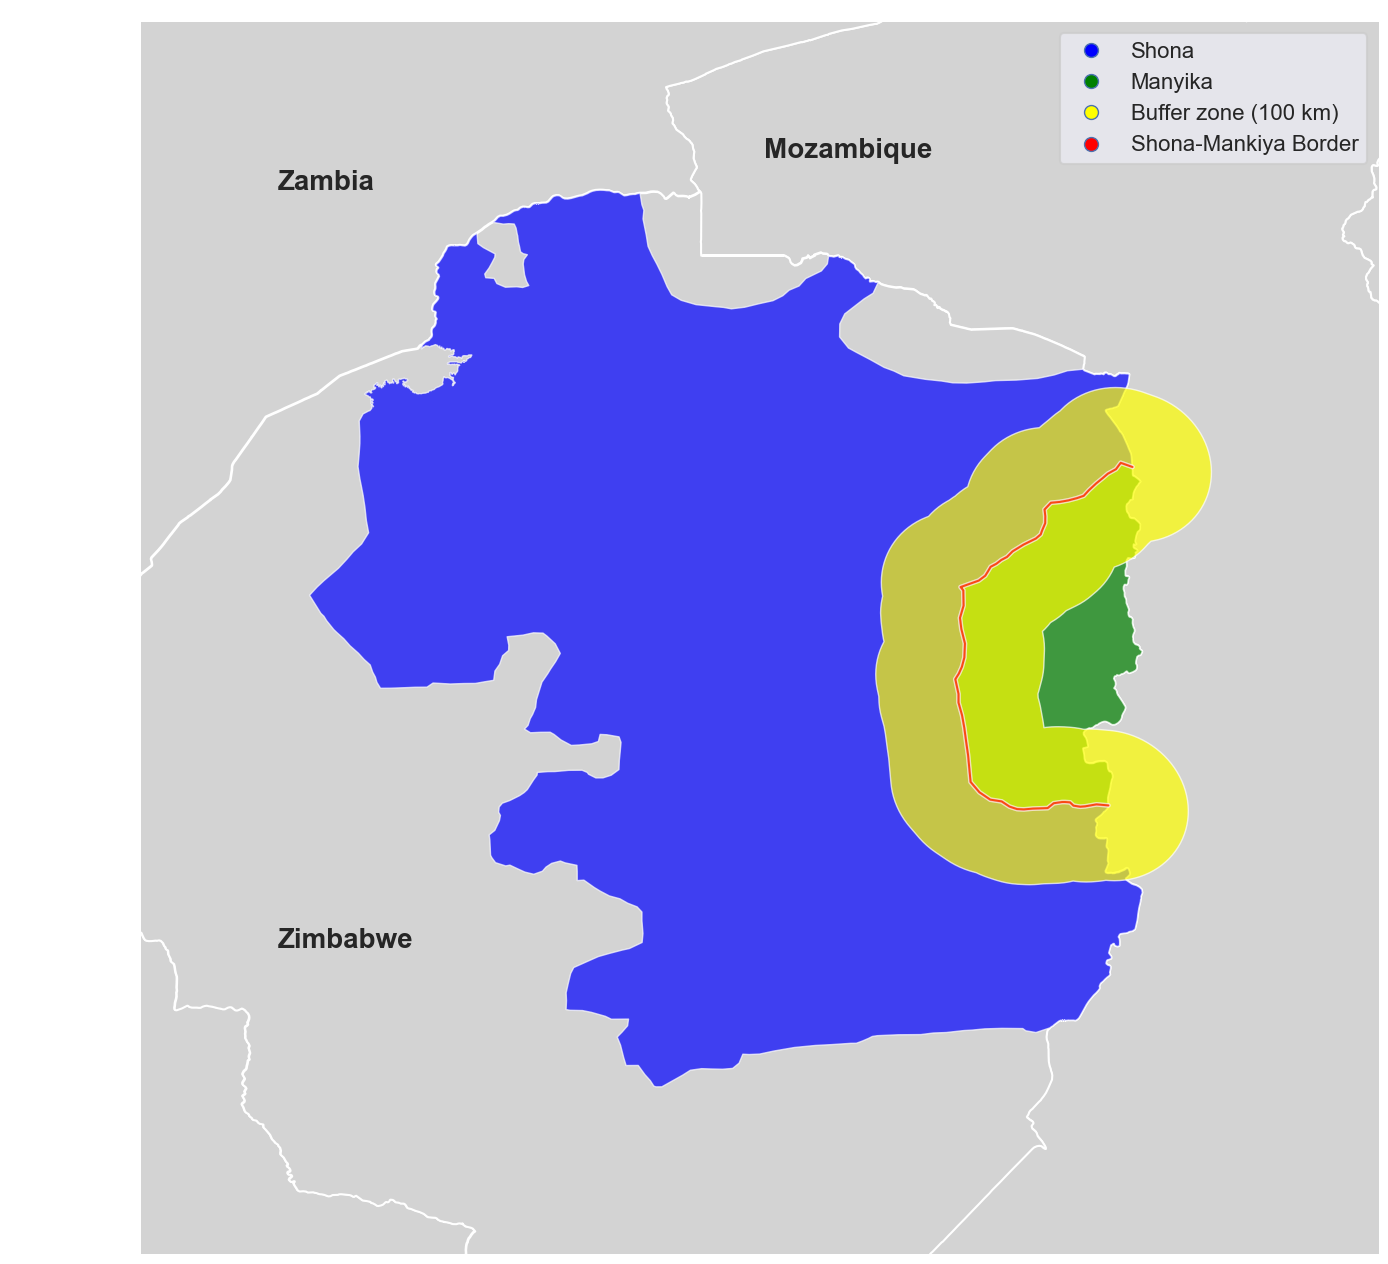

In [10]:
# Set up bounds of the figure
ethn_or = pd.concat([shona_or, manyika_or])
extent = pd.DataFrame([ethn_or.total_bounds,
                       buffer_or_wgs84.total_bounds,
                       border_or_wgs84.total_bounds,
                      ], columns=['xmin', 'ymin', 'xmax', 'ymax'])
xmin = extent['xmin'].min() - 1
ymin = extent['ymin'].min() - 1
xmax = extent['xmax'].max() + 1
ymax = extent['ymax'].max() + 1
extent = [xmin, ymin, xmax, ymax]

# Set the colors
cmap = ListedColormap(['blue', 'green', 'yellow', 'red'])
dfmap = pd.concat([ethn_or, buffer_or_wgs84, border_or_wgs84_buf]).reset_index()

# Retrieve unique labels
labels = dfmap['NAM_LABEL'].unique()

# Create categorical data type
cat_type = CategoricalDtype(categories=labels, ordered=True)

# Convert 'NAM_LABEL' column to categorical
dfmap['NAM_LABEL_fac'] = dfmap['NAM_LABEL'].astype(cat_type).cat.codes

# Plot
ax = gplt.choropleth(
        dfmap, hue='NAM_LABEL_fac',
        projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor=None, linewidth=1, 
        legend=True,
        legend_kwargs={'fontsize':16},
        cmap=cmap, 
        figsize=(24, 16),
        scheme = mc.UserDefined(dfmap['NAM_LABEL_fac'], bins=dfmap['NAM_LABEL_fac'].tolist()),
        legend_labels=dfmap['NAM_LABEL'].tolist(),
        rasterized=True,
        alpha=0.7#[[0.5, 1, 1, 1]]
    )
gplt.polyplot(
        africa_or, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', facecolor='lightgray',
        ax=ax,
        extent=extent,
    )
plt.annotate(text='Zimbabwe', xy=[0.2, 0.25], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Zambia', xy=[0.2, 0.85], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Mozambique', xy=[0.55, 0.875], xycoords='subfigure fraction', size=20, weight='bold')
plt.savefig(pathgraphs + 'figure-1-original-data.pdf', dpi=300, bbox_inches='tight')

# Table 1

This table directly replicates Table 1 from Dickens (2022). 

*Notes:*

*The estimated coefficient are normalized and thus the number do not coincide with DIckens (2022). See Table A1 for and exact replication*

*Python doesn't have a package that implements the `reghdfe` procedures.
For this replication we found that using a dummies for the two Language Families combined with dropping out singleton language groups provides the closest results.*


A summary of the columns:
- Column 1: No levels, Family Lang Fixed Effects
- Column 2: Include levels, Family Lang Fixed Effects
- Column 3: Include levels, Family Lang Fixed Effects, Geo controls
- Column 4: Include levels, Family Lang Fixed Effects, Spatial controls
- Column 5: Include levels, Family Lang FFixed EffectsE, Spatial controls + Geo controls
- Column 6: Include levels, Family Lang and country Fixed Effects, Spatial controls + Geo controls

In [11]:
# Define the variables of interest
var_of_interest = ['lingDist','csi_change_sd', 'csi_sd']

# Set up some controls
prod = ['csi_change', 'csi']
geog = ['malaria', 'elev', 'elev_sd', 'prec', 'prec_sd', 'temp', 'temp_sd']
spatial = ['ldist_lang', 'ldist_coast', 'ldist_border', 'ldist_lake', 'ldist_rivmaj', 
           'ldist_rivmin', 'ln_langPop', 'ln_langArea', 'langLat_diff', 'langLon_diff']

# Include the main covariates in the right side (variations and levels)
x_vars = ['csi_change_sd', 'csi_sd'] + prod

In [12]:
# Column 1: No levels, Family Lang FE
myvars = var_of_interest
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
py_est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est1_b = py_est1.params[['csi_change_sd', 'csi_sd']]
est1_se = py_est1.bse[['csi_change_sd', 'csi_sd']]
est1_p = py_est1.pvalues[['csi_change_sd', 'csi_sd']]
ad_R1 = py_est1.rsquared_adj
N1 = py_est1.nobs

# Column 2: Include levels, Family Lang FE
myvars = var_of_interest + prod
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
py_est2 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est2_b = py_est2.params[x_vars]
est2_se = py_est2.bse[x_vars]
est2_p = py_est2.pvalues[x_vars]
ad_R2 = py_est2.rsquared_adj
N2 = py_est2.nobs

# Column 3: Include levels, Family Lang FE, Geo controls
myvars = var_of_interest + prod + geog
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
py_est3 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est3_b = py_est3.params[x_vars]
est3_se = py_est3.bse[x_vars]
est3_p = py_est3.pvalues[x_vars]
ad_R3 = py_est3.rsquared_adj
N3 = py_est3.nobs

# Column 4: Include levels, Family Lang FE, Spatial controls
myvars = var_of_interest + prod + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
py_est4 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est4_b = py_est4.params[x_vars]
est4_se = py_est4.bse[x_vars]
est4_p = py_est4.pvalues[x_vars]
ad_R4 = py_est4.rsquared_adj
N4 = py_est4.nobs

# Column 5: Include levels, Family Lang FE, Spatial controls + Geo controls
myvars = var_of_interest + prod + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
py_est5 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est5_b = py_est5.params[x_vars]
est5_se = py_est5.bse[x_vars]
est5_p = py_est5.pvalues[x_vars]
ad_R5 = py_est5.rsquared_adj
N5 = py_est5.nobs

# Column 6: Include levels, Family Lang and country FE, Spatial controls + Geo controls
myvars = var_of_interest + prod + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor_same_country_50, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
py_est6 = smf.ols(myeq + ' + C(family1) + C(family2) + C(ccode1)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est6_b = py_est6.params[x_vars]
est6_se = py_est6.bse[x_vars]
est6_p = py_est6.pvalues[x_vars]
ad_R6 = py_est6.rsquared_adj
N6 = py_est6.nobs

## Output to HTML
html_table_1("table1")
latex_table_1("table1")

We display the table in a HTML format

In [13]:
HTML(filename= pathgraphs + "table1.html")

# Figure 2

We create heatmaps to see the correlation between our reconstructed buffers and Dickens measures of CSI.

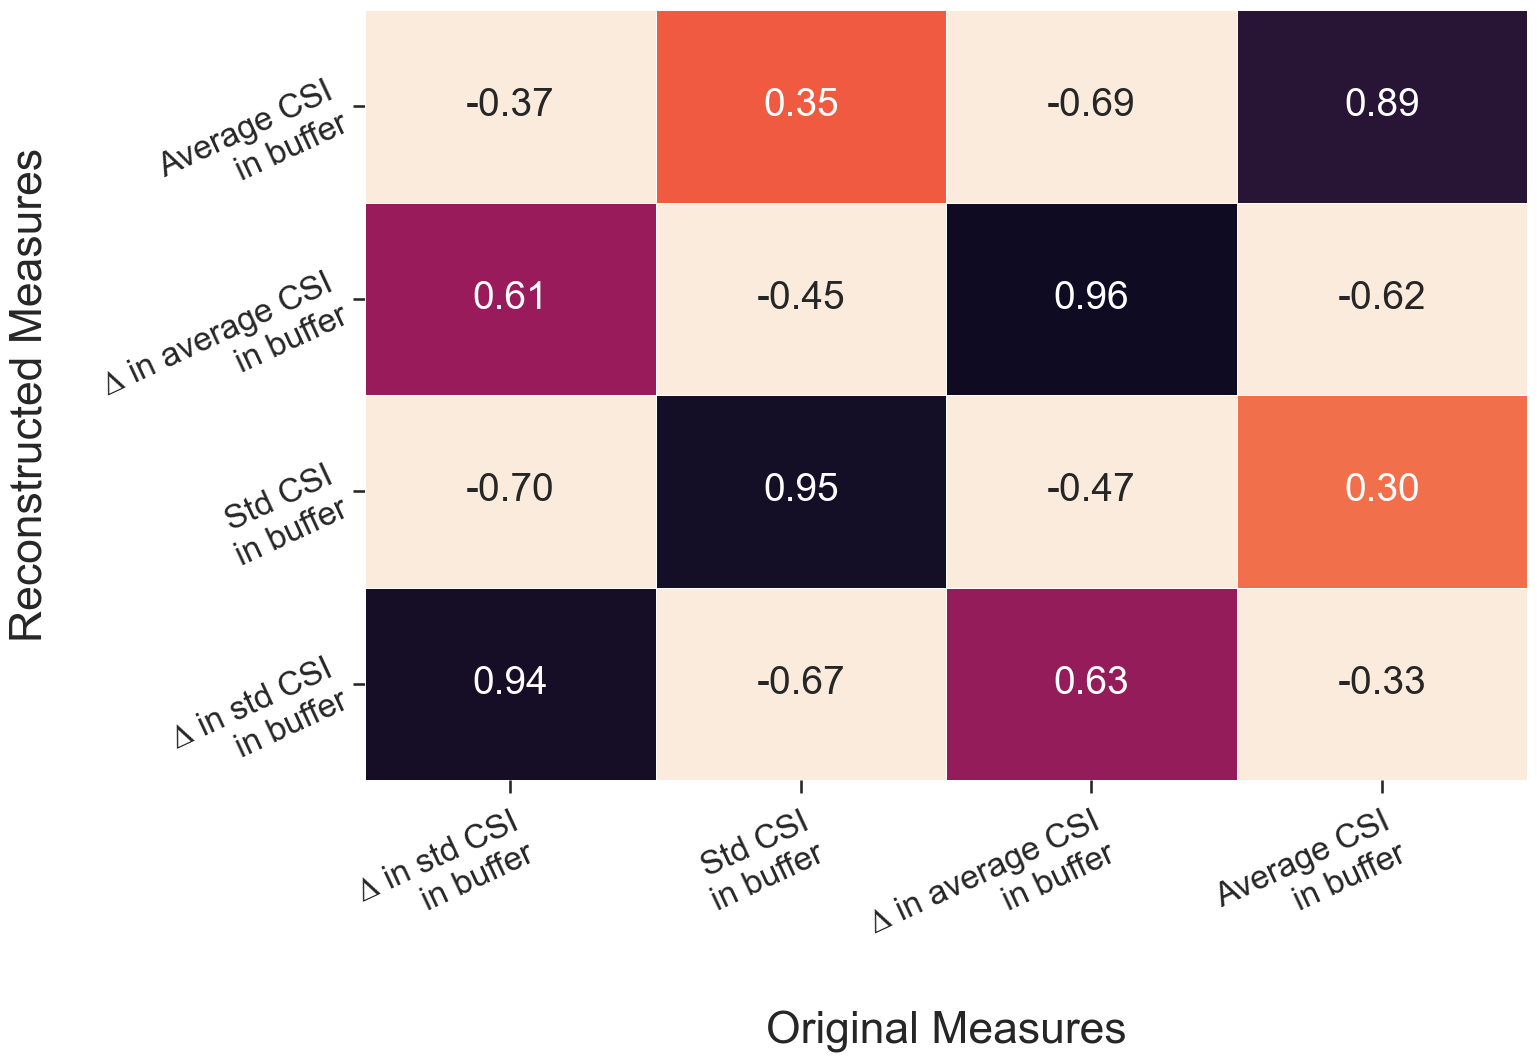

In [14]:
# Reconstructed Buffers for the Ethnologe v16
varx = ['csi_change_sd','csi_sd','csi_change','csi']
vary = ['csi_oj','csi_change_oj','csi_sd_oj','csi_change_sd_oj']

varx_names = ['Average CSI\n in buffer','∆ in average CSI\n in buffer','Std CSI\n in buffer','∆ in std CSI\n in buffer']
vary_names = reversed(varx_names)

myheatmap(dfor16, vary, varx, vary_names, varx_names, "Original Measures", "Reconstructed Measures", 'heatmap_v16', label_rotation = 25,  top_flip = False, pad_labels = (-.3, -.27), show = True)

# Table 2

In this longer table we want to understand if our alternative way of measurin buffers can capture the effects found in Dickens (2022).

A summary of the columns and the data used:
- Column 1: his data, his sample
- Column 2: his data, our sample v16
- Column 3: his data, our sample v17
- Column 4: our data, our sample v16
- Column 5 : our data, our sample v17
- Column 6 : our data alternative buffer, our sample v16
- Column 7 : our data alternative buffer, our sample v17

In [15]:
# Column 1: his data, his sample
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est1_b = est1.params[x_vars2]
est1_se = est1.bse[x_vars2]
est1_p = est1.pvalues[x_vars2]
ad_R1 = est1.rsquared_adj
N1 = est1.nobs

# Column 2: his data, our sample v16
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16[dfor16.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est2_b = est1.params[x_vars2]
est2_se = est1.bse[x_vars2]
est2_p = est1.pvalues[x_vars2]
ad_R2 = est1.rsquared_adj
N2 = est1.nobs

#  Column 3: his data, our sample v17
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17[dfor17.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est3_b = est1.params[x_vars2]
est3_se = est1.bse[x_vars2]
est3_p = est1.pvalues[x_vars2]
ad_R3 = est1.rsquared_adj
N3 = est1.nobs

#  Column 4: our data, our sample v16
x_vars2 = ['csi_change_sd_oj','csi_sd_oj','csi_change_oj','csi_oj']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est4_b = est1.params[x_vars2]
est4_se = est1.bse[x_vars2]
est4_p = est1.pvalues[x_vars2]
ad_R4 = est1.rsquared_adj
N4 = est1.nobs

#  Column 5 : our data, our sample v17
x_vars2 = ['csi_change_sd_oj','csi_sd_oj','csi_change_oj','csi_oj']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est5_b = est1.params[x_vars2]
est5_se = est1.bse[x_vars2]
est5_p = est1.pvalues[x_vars2]
ad_R5 = est1.rsquared_adj
N5 = est1.nobs

# Column 6 : our data alternative buffer, our sample v16
x_vars2 = ['csi_change_alt','csi_alt','csi','csi_change']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16[dfor16.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est6_b = est1.params[x_vars2]
est6_se = est1.bse[x_vars2]
est6_p = est1.pvalues[x_vars2]
ad_R6 = est1.rsquared_adj
N6 = est1.nobs

# Column 7 : our data alternative buffer, our sample v17
x_vars2 = ['csi_change_alt','csi_alt','csi','csi_change']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17[dfor17.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est7_b = est1.params[x_vars2]
est7_se = est1.bse[x_vars2]
est7_p = est1.pvalues[x_vars2]
ad_R7 = est1.rsquared_adj
N7 = est1.nobs

## Output to HTML and latex
html_table_2("table2")
latex_table_2("table2")

In [16]:
display(HTML(filename=pathgraphs + "table2.html"))

In [17]:
# This block of code is used to understand what obs we don't have in the original dataset

dickens_buffers = dfor16.loc[dfor16.csi.isna() == False]
our_buffers = dfor16.loc[dfor16.csi_oj.isna() == False]

set(dickens_buffers.identifier) - set(our_buffers.identifier)

{'BZX-MLI-FFM-MLI', 'XMW-MDG-PLT-MDG'}

# Figure 3

We create heatmaps to see the correlation between our alternative buffers and Dicknes measures of CSI.

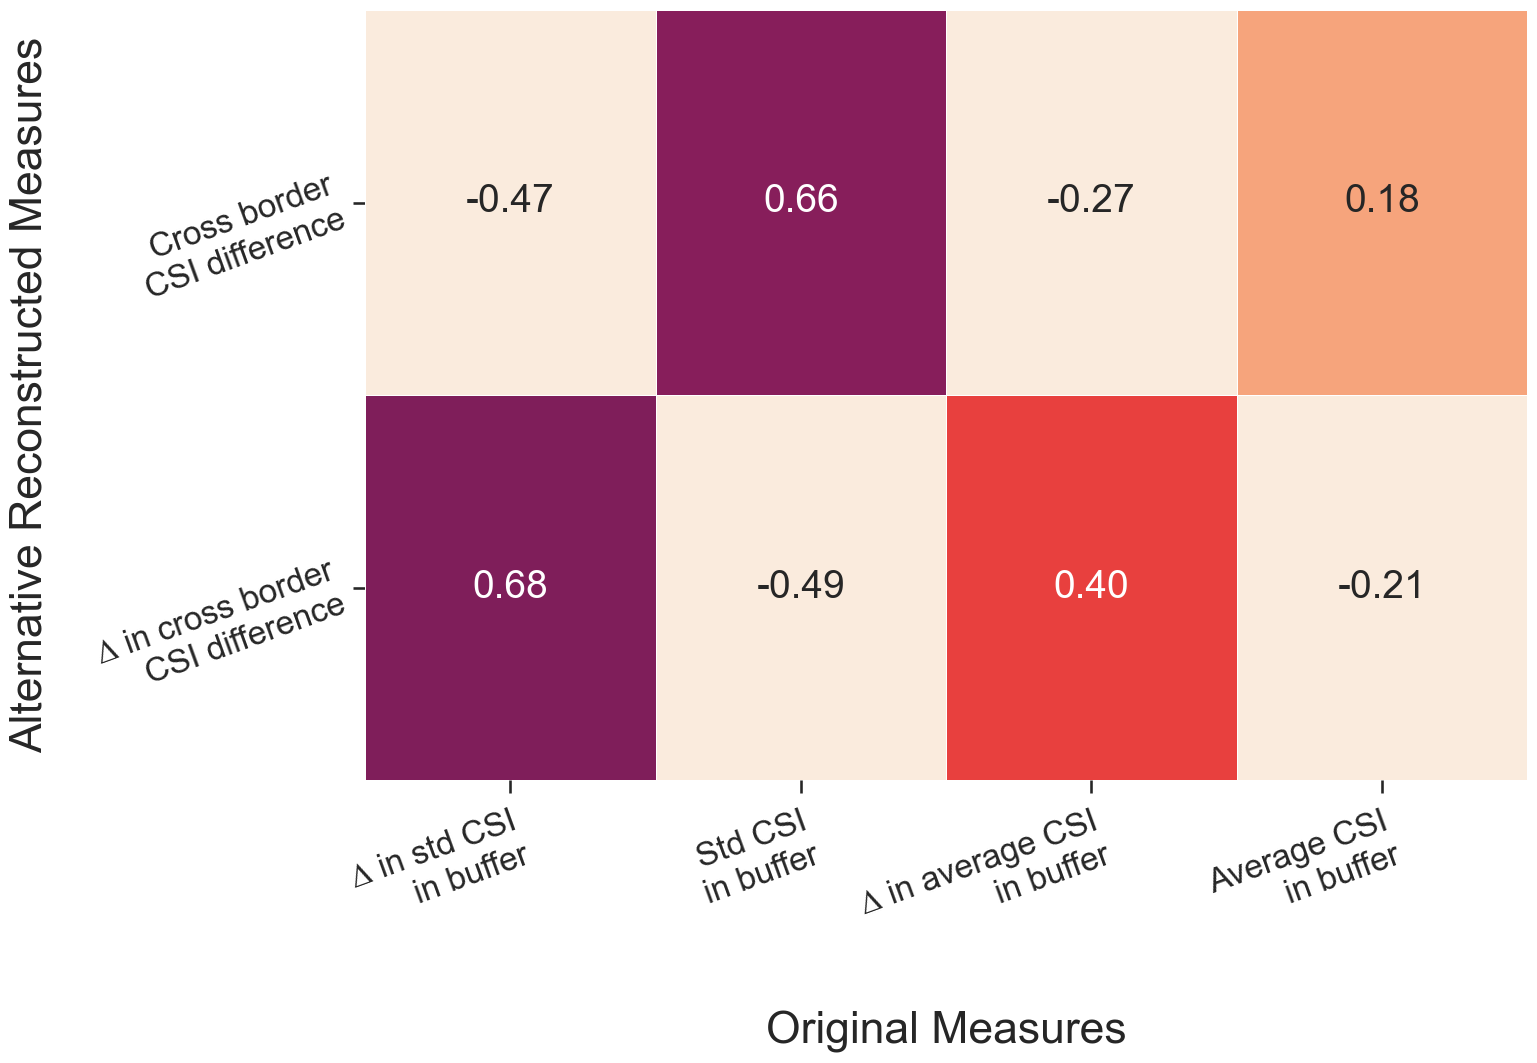

In [18]:
# Reconstructed Buffers for the Ethnologe v16
var1 = ['csi_alt','csi_change_alt']
var2 = ['csi_change_sd','csi_sd','csi_change','csi']

# The code that creates the correlation matrix does a wierd sorting of columns. So we need to reverse the names of the labels

var1_names = reversed(['Average CSI\n in buffer','∆ in average CSI\n in buffer','Std CSI\n in buffer','∆ in std CSI\n in buffer'])
var2_names = ['Cross border\nCSI difference','∆ in cross border\nCSI difference']

myheatmap(dfor16, var1, var2, var1_names, var2_names, "Original Measures", "Alternative Reconstructed Measures", 'heatmap_v16_alt', pad_labels = (-.3, -.27), show = True)

# Figure 5

In [19]:
# Need to find the variables of singlec crops
variable_names = dfor16.columns.tolist()
regex_pattern = re.compile(r'.*crop_alt.*(mean|std)')
crop_alt_var_list = [var for var in variable_names if regex_pattern.match(var)]

crop_var_list = [var for var in variable_names if re.match(r'.*crop.*(mean|std)', var)]
crop_var_list = [var for var in crop_var_list if var not in crop_alt_var_list]

# I will also need the unique crop names
crop_names = list(set([item.replace('crop_','').replace('lomean','').replace('lostd','') for item in crop_var_list]))
crop_names.sort()

# I'm only gonna have the main crop, not subcrops (e.g. only have wheat and not wheatspring, wheatwinter, etc.)
not_allowed_list = ['springbarley', 'winterbarley', 'maizetrl', 'maizestr', 'maizetrh', 'winterrye', 'springrye', 'sorghumstr','sorghumtrh', 'sorghumtrl', 'winterwheat', 'springwheat', 'buckwheat']
for item in not_allowed_list:
    crop_names.remove(item)

# Need to enhance the not allowed list
not_allowed_list = ['crop_' + item + 'lomean' for item in not_allowed_list] + ['crop_' + item + 'lostd' for item in not_allowed_list] + \
                   ['crop_alt_' + item + 'lomean' for item in not_allowed_list] + ['crop_alt_' + item + 'lostd' for item in not_allowed_list]  



## Panel A: individual regressions

In [20]:
# Get the models for the crop variables
model_list = []
used_crop_var = crop_names.copy()
for crop_var in crop_names:
    vars_now = [element for element in crop_alt_var_list if ((crop_var in element) & (element not in not_allowed_list))]
    myvars = ['lingDist'] + vars_now + ['csi_oj','csi_change_oj'] + geog + spatial
    [mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
    try:
        est = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})
        model_list.append(est)
    except:
        # print(crop_var + 'had 0 variation \n')
        used_crop_var.remove(crop_var)
        pass
# First I need to create the dataframes like this and then need to concatenate them
size_xvars = 2

data = {
    'coeff_name': [],
    'coef': [],
    'coef_n': [],
    'model': [],
    'ci_min': [],
    'ci_max': []
}

df = pd.DataFrame(data)

for (est,crop_var) in zip(model_list, used_crop_var):
    vars_now = [element for element in crop_alt_var_list if ((crop_var in element) & (element not in not_allowed_list))]
    ci = est.conf_int(alpha=0.05).loc[vars_now]
    data = {
        'coeff_name': vars_now,
        'coef': est.params[vars_now],
        'coef_n': [1,0],
        'model': [crop_var] * size_xvars,
        'ci_min': ci.loc[:,0],
        'ci_max': ci.loc[:,1]
    }
    data = pd.DataFrame(data)
    df = pd.concat([df, data], axis=0)

used_crop_var.sort(reverse=True)

step_size = 3
value_map_d = {name:i for (name,i) in zip(used_crop_var,range(0,len(used_crop_var)*step_size,step_size))}
df['y_vals'] = df['model'].apply(lambda x: value_map_d.get(x))

df = df.sort_values(by='y_vals', ascending = False).reset_index(drop=True)
df


,coeff_name,coef,coef_n,model,ci_min,ci_max,y_vals
0,crop_alt_alfalfalostd,0.015889,1.0,alfalfa,-0.015967,0.047746,117
1,crop_alt_alfalfalomean,-0.003752,0.0,alfalfa,-0.035285,0.027781,117
2,crop_alt_bananalostd,0.024924,1.0,banana,-0.005307,0.055154,114
3,crop_alt_bananalomean,0.011643,0.0,banana,-0.019624,0.042910,114
4,crop_alt_barleylostd,0.003051,1.0,barley,-0.027162,0.033263,111
...,...,...,...,...,...,...,...
75,crop_alt_whitepotatolomean,0.001514,0.0,whitepotato,-0.030413,0.033440,6
76,crop_alt_whiteyamlostd,0.015372,1.0,whiteyam,-0.015161,0.045905,3
77,crop_alt_whiteyamlomean,0.018257,0.0,whiteyam,-0.018932,0.055445,3
78,crop_alt_yamslostd,0.013383,1.0,yams,-0.018386,0.045151,0


C:\Users\48672590\AppData\Local\Temp\ipykernel_3184\806243970.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_df.coeff_name = var_df.coeff_name.str.replace('crop_','').str.replace('alt_','').str.replace('lomean','').str.replace('lostd','')
C:\Users\48672590\AppData\Local\Temp\ipykernel_3184\806243970.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_df.sort_values('coef', inplace=True, ascending = False)


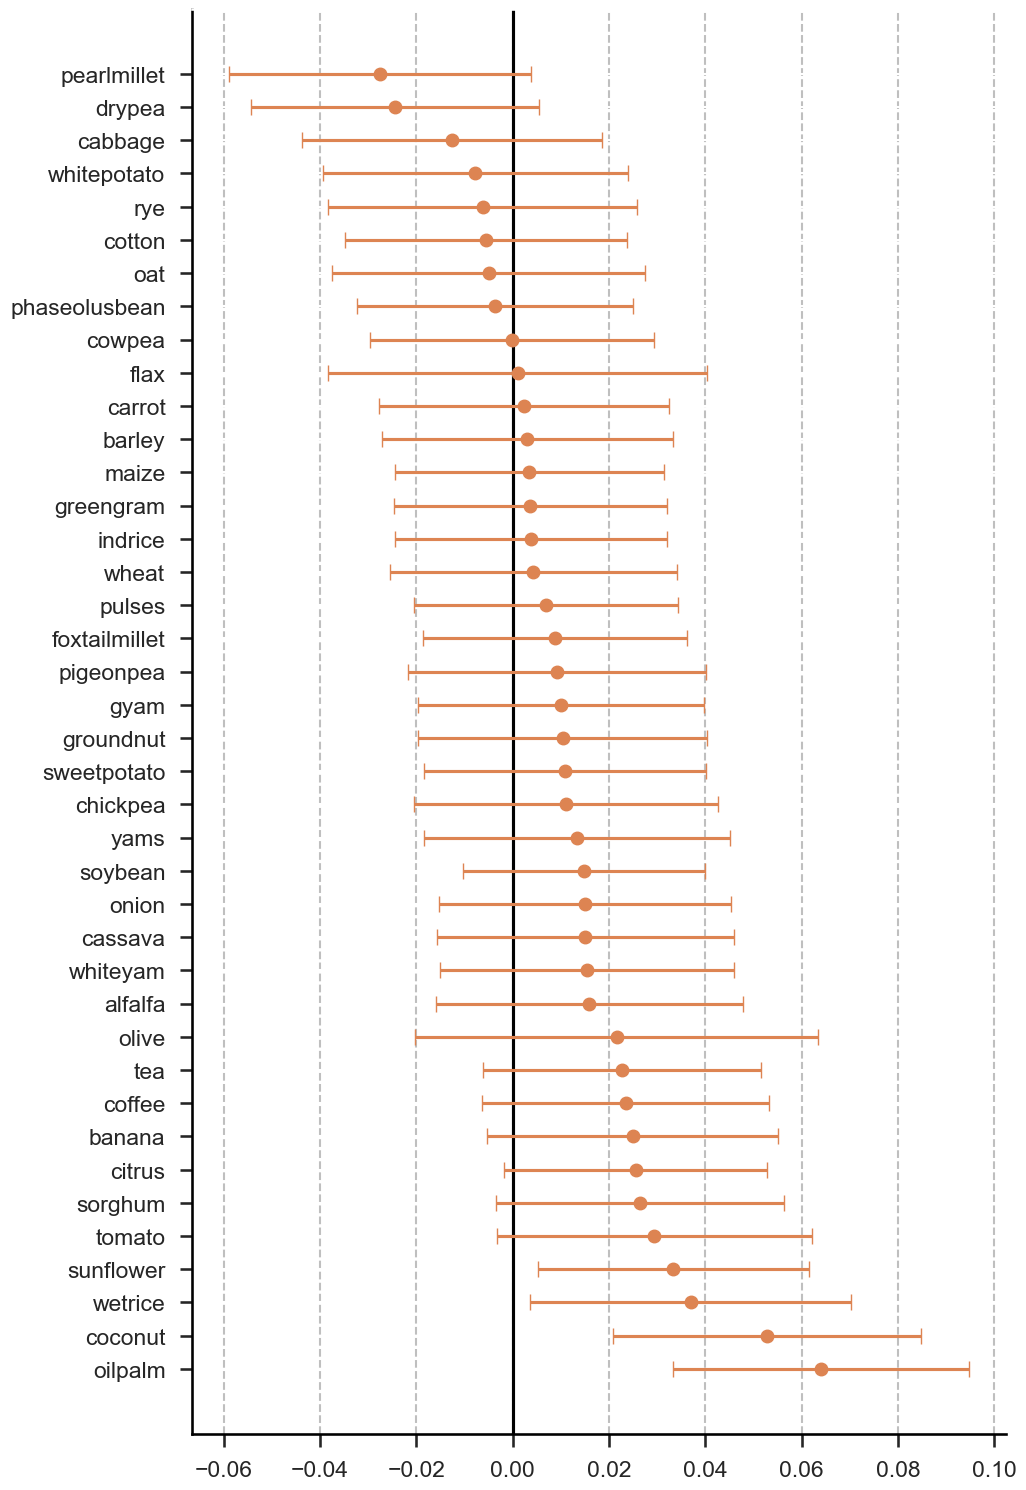

In [21]:
# CHOSE 1 TO DISPLAY THE SD AND 0 TO DISPLAY THE MEAN OF EACH CROP
display_coef = 1

# Plot the coef
# Create a plot per measure
# 1 is for std, 0 is for mean
df_aux = df.copy()

fig, ax = plt.subplots()
fig.set_size_inches(10.5, 18.5)
ax.axvline(x=0, color='black')


var_df = df_aux[(df_aux.coef_n == display_coef)]
var_df.coeff_name = var_df.coeff_name.str.replace('crop_','').str.replace('alt_','').str.replace('lomean','').str.replace('lostd','')
var_df.sort_values('coef', inplace=True, ascending = False)
ax.errorbar(var_df['coef'], var_df['coeff_name'], xerr=[abs(var_df.coef - var_df.ci_min)], linestyle="none", 
            color = sns.color_palette(n_colors=2)[1], capsize=6, marker = 'o')

# Modify grid and axis lines
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.tick_params(left=True, bottom=True,pad = 10)
ax.set_facecolor('white')
ax.xaxis.grid(c='grey',linestyle = '--', alpha = .5)
plt.savefig( pathgraphs + 'crops_ALT_separate.pdf', dpi=300, bbox_inches='tight')

## Panel B: Joint Regression

C:\Users\48672590\AppData\Local\Temp\ipykernel_3184\3174281399.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mydf['cluster_'+v] = mydf[v].astype('category').cat.codes
C:\Users\48672590\AppData\Local\Temp\ipykernel_3184\3174281399.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mydf['cluster_'+v] = mydf[v].astype('category').cat.codes
C:\Users\48672590\AppData\Local\Temp\ipykernel_3184\1521309155.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

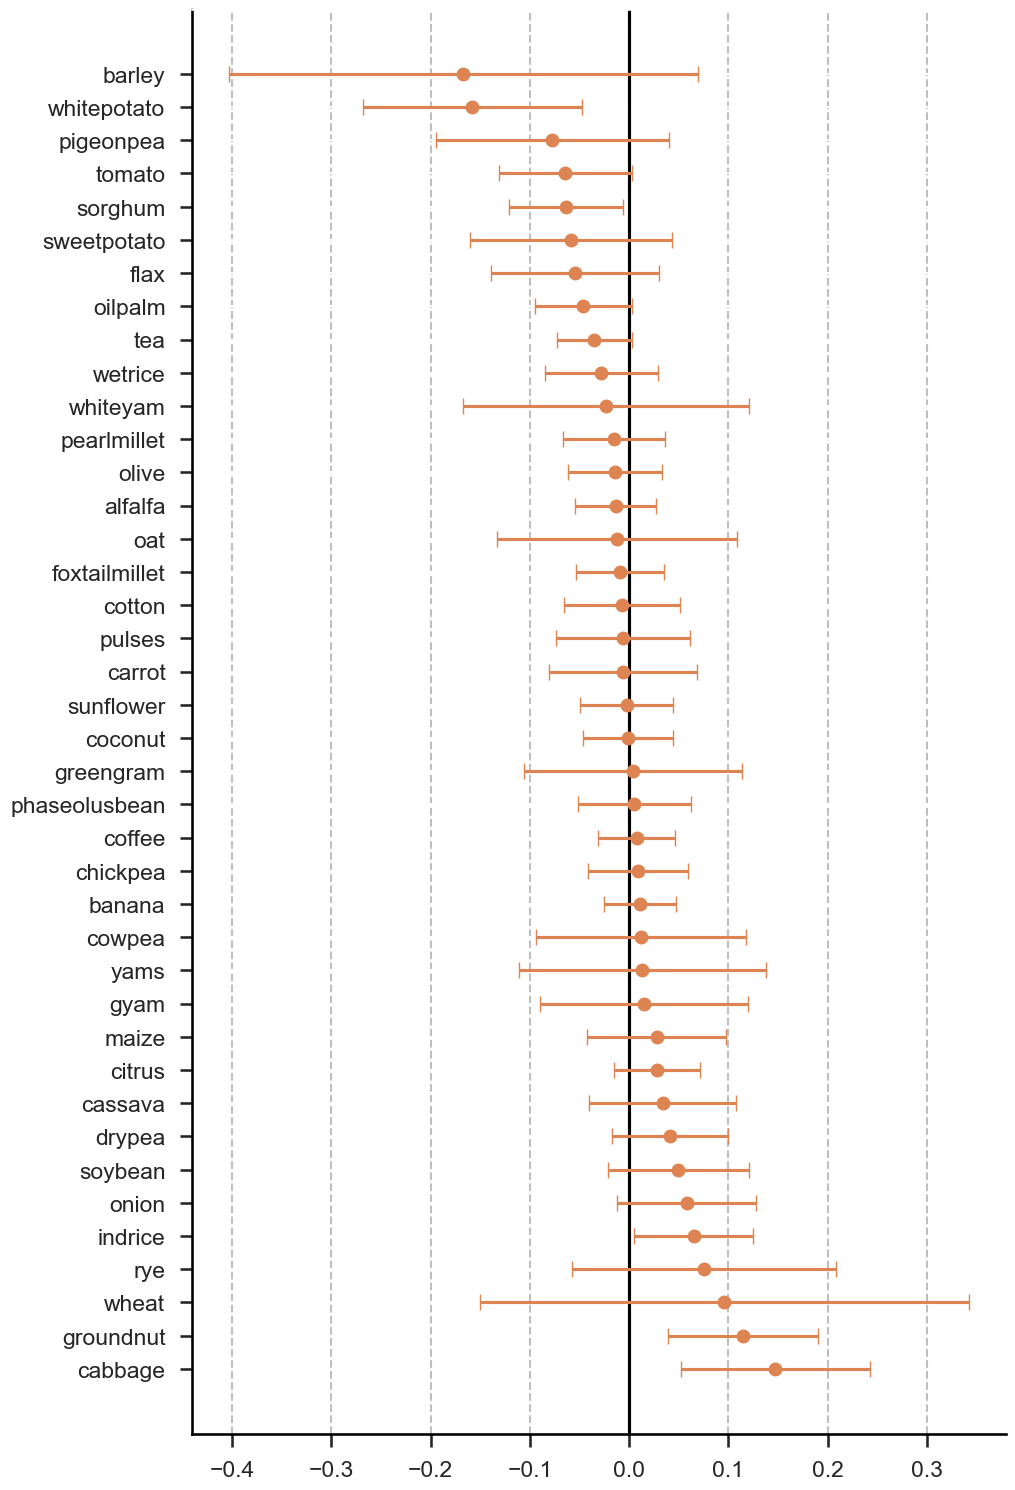

In [22]:
# CHOSE 1 TO DISPLAY THE SD AND 0 TO DISPLAY THE MEAN OF EACH CROP
display_coef = 1

# need to use the `used_crop_var` to bet out those that have 0 in the border
crop_vars_in_reg = [element for element in crop_alt_var_list if (any(crop_var in element for crop_var in used_crop_var) & (element not in not_allowed_list))]

myvars = ['lingDist'] + crop_vars_in_reg + ['csi_oj','csi_change_oj'] + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est_crop = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

size_xvars = 2

data = {
    'coeff_name': [],
    'coef': [],
    'coef_n': [],
    'model': [],
    'ci_min': [],
    'ci_max': []
}

df = pd.DataFrame(data)

for crop_var in used_crop_var:
    vars_now = [element for element in crop_alt_var_list if ((crop_var in element) & (element not in not_allowed_list))]
    ci = est_crop.conf_int(alpha=0.05).loc[vars_now]
    data = {
        'coeff_name': vars_now,
        'coef': est_crop.params[vars_now],
        'coef_n': [0,1],
        'model': [crop_var] * size_xvars,
        'ci_min': ci.loc[:,0],
        'ci_max': ci.loc[:,1]
    }
    data = pd.DataFrame(data)
    df = pd.concat([df, data], axis=0)

step_size = 3
value_map_d = {name:i for (name,i) in zip(used_crop_var,range(0,len(used_crop_var)*step_size,step_size))}
df['y_vals'] = df['model'].apply(lambda x: value_map_d.get(x))

df = df.sort_values(by='y_vals', ascending = False).reset_index(drop=True)

# Plot the coef
# Create a plot per measure
# 1 is for std, 0 is for mean
df_aux = df.copy()

fig, ax = plt.subplots()
fig.set_size_inches(10.5, 18.5)
ax.axvline(x=0, color='black')


var_df = df_aux[(df_aux.coef_n == display_coef)]
var_df.coeff_name = var_df.coeff_name.str.replace('crop_','').str.replace('alt_','').str.replace('lomean','').str.replace('lostd','')
var_df.sort_values('coef', inplace=True, ascending = False)
ax.errorbar(var_df['coef'], var_df['coeff_name'], xerr=[abs(var_df.coef - var_df.ci_min)], linestyle="none", 
            color = sns.color_palette(n_colors=2)[1], capsize=6, marker = 'o')

# Modify grid and axis lines
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.tick_params(left=True, bottom=True,pad = 10)
ax.set_facecolor('white')
ax.xaxis.grid(c='grey',linestyle = '--', alpha = .5)
plt.savefig( pathgraphs + 'crops_ALT_same_reg.pdf', dpi=300, bbox_inches='tight')

# Appendix 

## Table A1

In [23]:
x_vars = ['csi_change_sd','csi_sd','csi_change','csi']

# Column 1: No levels, Family Lang FE
myvars = var_of_interest
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
py_est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est1_b = py_est1.params[['csi_change_sd', 'csi_sd']]
est1_se = py_est1.bse[['csi_change_sd', 'csi_sd']]
est1_p = py_est1.pvalues[['csi_change_sd', 'csi_sd']]
ad_R1 = py_est1.rsquared_adj
N1 = py_est1.nobs

# Column 2: Include levels, Family Lang FE
myvars = var_of_interest + prod
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
py_est2 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est2_b = py_est2.params[x_vars]
est2_se = py_est2.bse[x_vars]
est2_p = py_est2.pvalues[x_vars]
ad_R2 = py_est2.rsquared_adj
N2 = py_est2.nobs

# Column 3: Include levels, Family Lang FE, Geo controls
myvars = var_of_interest + prod + geog
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
py_est3 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est3_b = py_est3.params[x_vars]
est3_se = py_est3.bse[x_vars]
est3_p = py_est3.pvalues[x_vars]
ad_R3 = py_est3.rsquared_adj
N3 = py_est3.nobs

# Column 4: Include levels, Family Lang FE, Spatial controls
myvars = var_of_interest + prod + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
py_est4 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est4_b = py_est4.params[x_vars]
est4_se = py_est4.bse[x_vars]
est4_p = py_est4.pvalues[x_vars]
ad_R4 = py_est4.rsquared_adj
N4 = py_est4.nobs

# Column 5: Include levels, Family Lang FE, Spatial controls + Geo controls
myvars = var_of_interest + prod + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
py_est5 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est5_b = py_est5.params[x_vars]
est5_se = py_est5.bse[x_vars]
est5_p = py_est5.pvalues[x_vars]
ad_R5 = py_est5.rsquared_adj
N5 = py_est5.nobs

# Column 6: Include levels, Family Lang and country FE, Spatial controls + Geo controls
myvars = var_of_interest + prod + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor_same_country_50, FE=False, zscores=False, cluster_cols = ['langID1', 'langID2'])
py_est6 = smf.ols(myeq + ' + C(family1) + C(family2) + C(ccode1)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est6_b = py_est6.params[x_vars]
est6_se = py_est6.bse[x_vars]
est6_p = py_est6.pvalues[x_vars]
ad_R6 = py_est6.rsquared_adj
N6 = py_est6.nobs

## Output to HTML
html_table_1("tableA1")
latex_table_1("tableA1")

In [24]:
HTML(filename= pathgraphs + "tableA1.html")

## Table A2

## Figure B1

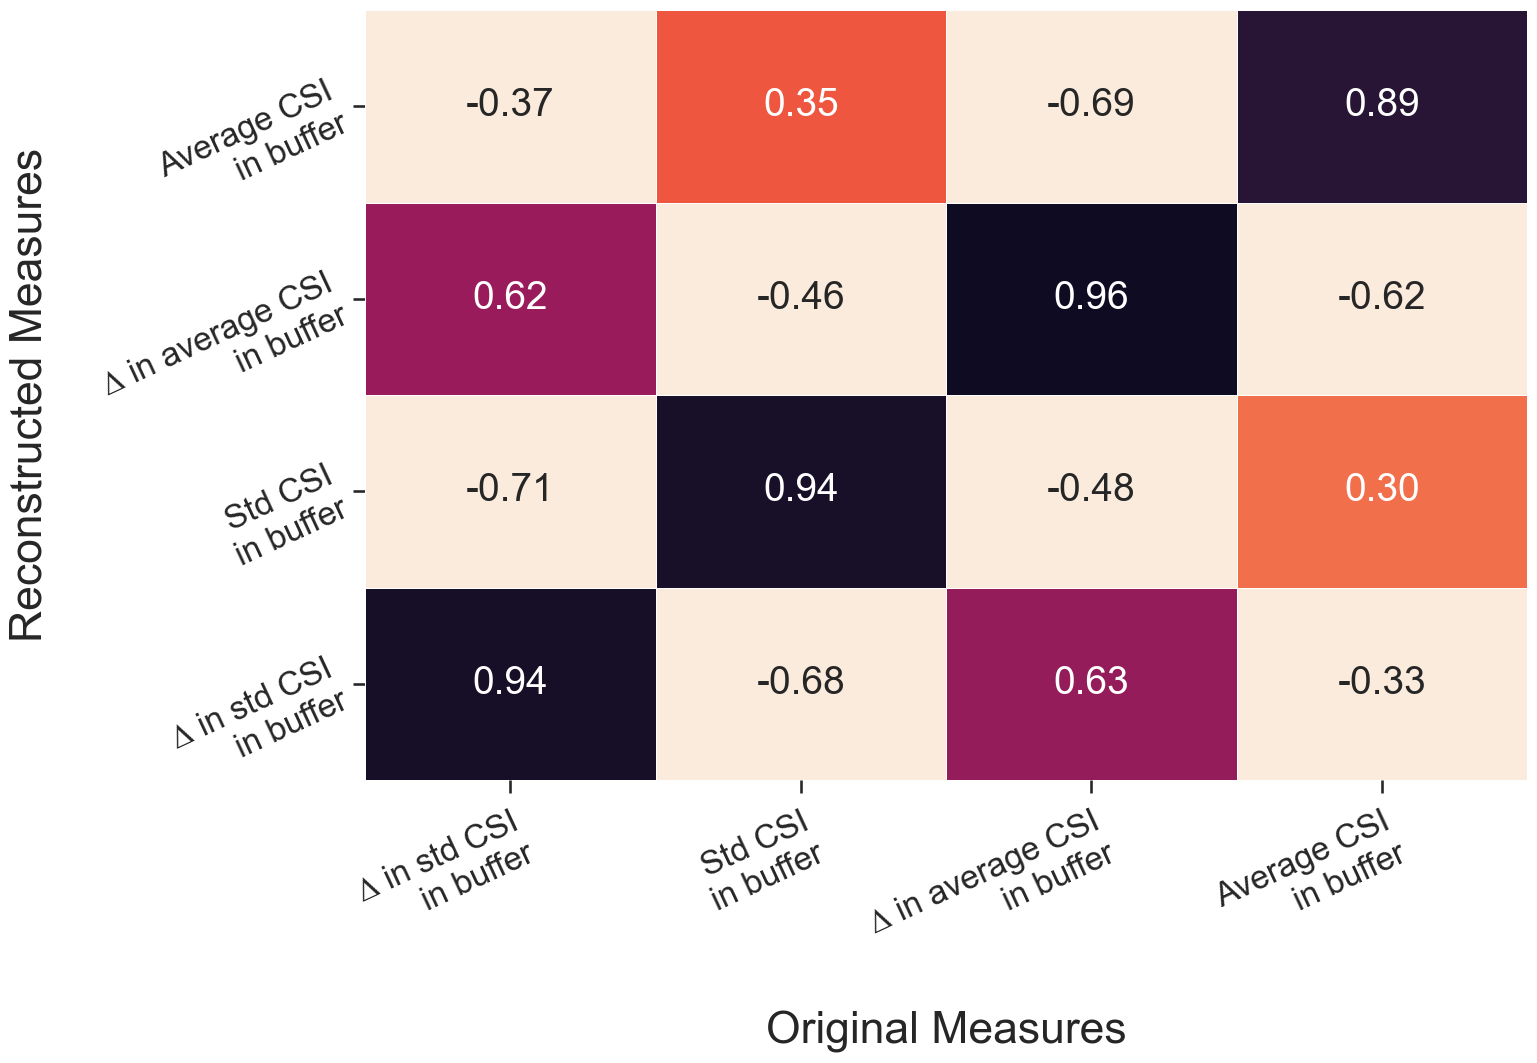

In [25]:
# Reconstructed Buffers for the Ethnologe v16
varx = ['csi_change_sd','csi_sd','csi_change','csi']
vary = ['csi_oj','csi_change_oj','csi_sd_oj','csi_change_sd_oj']

varx_names = ['Average CSI\n in buffer','∆ in average CSI\n in buffer','Std CSI\n in buffer','∆ in std CSI\n in buffer']
vary_names = reversed(varx_names)

myheatmap(dfor17, vary, varx, vary_names, varx_names, "Original Measures", "Reconstructed Measures", 'heatmap_v17', label_rotation = 25,  top_flip = False, pad_labels = (-.3, -.27), show = True)

In [26]:
# Column 1: his data, his sample
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est1_b = est1.params[x_vars2]
est1_se = est1.bse[x_vars2]
est1_p = est1.pvalues[x_vars2]
ad_R1 = est1.rsquared_adj
N1 = est1.nobs

# Column 2: his data, our sample v16
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16[dfor16.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est2_b = est1.params[x_vars2]
est2_se = est1.bse[x_vars2]
est2_p = est1.pvalues[x_vars2]
ad_R2 = est1.rsquared_adj
N2 = est1.nobs

#  Column 3: his data, our sample v17
x_vars2 = ['csi_change_sd','csi_sd','csi_change','csi']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17[dfor17.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est3_b = est1.params[x_vars2]
est3_se = est1.bse[x_vars2]
est3_p = est1.pvalues[x_vars2]
ad_R3 = est1.rsquared_adj
N3 = est1.nobs

#  Column 4: our data, our sample v16
x_vars2 = ['csi_change_sd_oj','csi_sd_oj','csi_change_oj','csi_oj']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est4_b = est1.params[x_vars2]
est4_se = est1.bse[x_vars2]
est4_p = est1.pvalues[x_vars2]
ad_R4 = est1.rsquared_adj
N4 = est1.nobs

#  Column 5 : our data, our sample v17
x_vars2 = ['csi_change_sd_oj','csi_sd_oj','csi_change_oj','csi_oj']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est5_b = est1.params[x_vars2]
est5_se = est1.bse[x_vars2]
est5_p = est1.pvalues[x_vars2]
ad_R5 = est1.rsquared_adj
N5 = est1.nobs

# Column 6 : our data alternative buffer, our sample v16
x_vars2 = ['csi_change_alt','csi_alt','csi','csi_change']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16[dfor16.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est6_b = est1.params[x_vars2]
est6_se = est1.bse[x_vars2]
est6_p = est1.pvalues[x_vars2]
ad_R6 = est1.rsquared_adj
N6 = est1.nobs

# Column 7 : our data alternative buffer, our sample v17
x_vars2 = ['csi_change_alt','csi_alt','csi','csi_change']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor17[dfor17.csi_oj.isna() == False], FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est1 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

# Store results
est7_b = est1.params[x_vars2]
est7_se = est1.bse[x_vars2]
est7_p = est1.pvalues[x_vars2]
ad_R7 = est1.rsquared_adj
N7 = est1.nobs

## Output to HTML and latex
html_table_2("tableA2")
latex_table_2("tableA2")

In [27]:
HTML(filename=pathgraphs+"tableA2.html")

## Figure B2
### Panel A: Original Measures

In [28]:
# here we use our own measures
x_vars2 = ['csi_change_sd_oj','csi_sd_oj','csi_change_oj','csi_oj']

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16_25, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est25 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est50 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

[mydf, myeq, clustercols] = mysample(myvars , dfor16_100, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est100 = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor_same_country_25, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est25fe = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

[mydf, myeq, clustercols] = mysample(myvars , dfor_same_country_50, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est50fe = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

[mydf, myeq, clustercols] = mysample(myvars , dfor_same_country_100, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est100fe = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

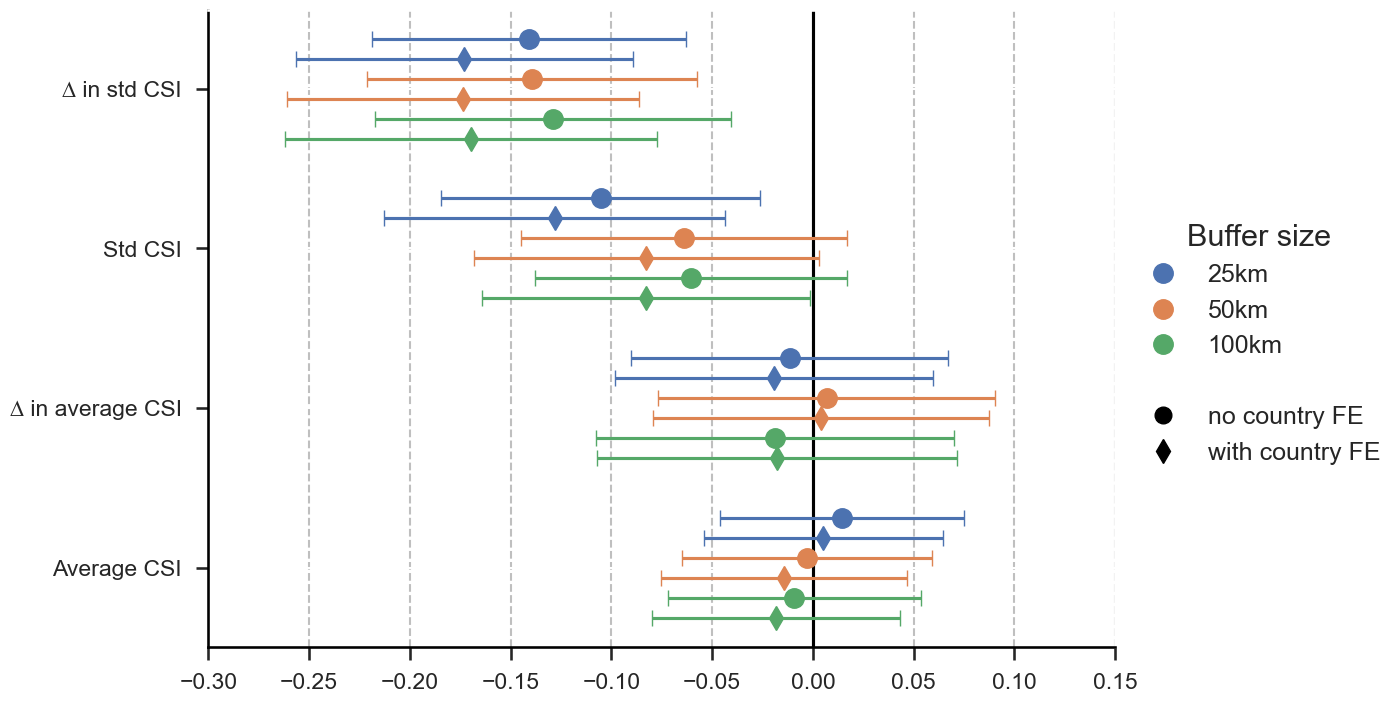

In [29]:
# Code to get the coef figure
# First I need to create the dataframes like this and then need to concatenate them
size_xvars = len(x_vars2)

data = {
    'coeff_name': [],
    'coef': [],
    'model': [],
    'ci_min': [],
    'ci_max': []
}

df = pd.DataFrame(data)

for (est,name) in zip([est25, est50, est100, est25fe, est50fe, est100fe], ['25km', '50km', '100km','25km FE', '50km FE', '100km FE']):
    ci = est.conf_int(alpha=0.05).loc[x_vars2]
    data = {
        'coeff_name': x_vars2,
        'coef': est.params[x_vars2],
        'model': [name] * size_xvars,
        'ci_min': ci.loc[:,0],
        'ci_max': ci.loc[:,1]
    }
    data = pd.DataFrame(data)
    df = pd.concat([df, data], axis=0)
    
value_map_d = {'csi_change_sd_oj':12.0,'csi_sd_oj':8.0,'csi_change_oj':4.0, 'csi_oj': 0.0}
df['y_vals'] = df['coeff_name'].apply(lambda x: value_map_d.get(x))
model_offset_map = {'25km': 1.25, '25km FE': .75, '50km': 0.25,  '50km FE': -0.25, '100km': -0.75, '100km FE': -1.25}
df['y_vals'] = df['y_vals'] + df['model'].apply(lambda x: model_offset_map.get(x))

df = df.sort_values(by='y_vals', ascending = False).reset_index(drop=True)

fig, ax = plt.subplots()
ax.axvline(x=0, color='black')

models = ['25km', '50km', '100km']
for (model,color_point) in zip(models,sns.color_palette(n_colors=len(models))):
    var_df = df[df.model == model]
    ax.errorbar(var_df['coef'], var_df['y_vals'], xerr=[abs(var_df.coef - var_df.ci_min)], linestyle="none", 
                color = color_point, capsize=6, marker = 'o', markersize = 14, label = model)

models = ['25km FE', '50km FE', '100km FE']
for (model,color_point) in zip(models,sns.color_palette(n_colors=len(models))):
    var_df = df[df.model == model]
    ax.errorbar(var_df['coef'], var_df['y_vals'], xerr=[abs(var_df.coef - var_df.ci_min)], linestyle="none", 
                color = color_point, capsize=6, marker = 'd', markersize = 12, label = model)

        
ax.set_yticks(list(value_map_d.values()))
ax.set_yticklabels(reversed(['Average CSI','∆ in average CSI','Std CSI','∆ in std CSI']))

# modify legend
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles] # eliminate the error bars and lines from the legend

# add marker types
circle_m = mlines.Line2D([], [], linewidth = 0, color='black', marker='o', markersize=12)
diamond_m = mlines.Line2D([], [], linewidth = 0, color='black', marker='d', markersize=12)
spacer_m = mlines.Line2D([], [], linewidth = 0, color='black', marker="*", markersize=0)

ax.legend(handles[0:3] + [spacer_m, circle_m, diamond_m], labels[0:3] + ['','no country FE','with country FE'], title='Buffer size', title_fontsize = 22, fontsize = 18, 
          bbox_to_anchor=(1, 0.7), framealpha = 0)

# save x_ticks and labels for the next plot
xticks_coef = ax.get_xticks()
xlabels_coef = ax.get_xticklabels()

ax.set_xticks(xticks_coef)
ax.set_xticklabels(xlabels_coef)

# Modify grid and axis lines
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.tick_params(left=True, bottom=True,pad = 10)
ax.set_facecolor('white')
ax.xaxis.grid(c='grey',linestyle = '--', alpha = .5)
plt.savefig( pathgraphs + 'coef_plot_buffer_FE.pdf', dpi=300, bbox_inches='tight')

### Panel B: Alternative Measure

In [30]:
x_vars2 = ['csi_change_alt','csi_alt','csi_change_oj','csi_oj']
myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor16_25, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est25alt = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

[mydf, myeq, clustercols] = mysample(myvars , dfor16, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est50alt = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

[mydf, myeq, clustercols] = mysample(myvars , dfor16_100, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est100alt = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})


x_vars2 = ['csi_change_alt','csi_alt','csi_change_oj','csi_oj']
myvars = ['lingDist'] + x_vars2 + geog + spatial
[mydf, myeq, clustercols] = mysample(myvars , dfor_same_country_25, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est25alt_FE = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

[mydf, myeq, clustercols] = mysample(myvars , dfor_same_country_50, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est50alt_FE = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

[mydf, myeq, clustercols] = mysample(myvars , dfor_same_country_100, FE=False, zscores=True, cluster_cols = ['langID1', 'langID2'])
est100alt_FE = smf.ols(myeq + '+ C(family1) + C(family2)', data=mydf).fit(cov_type='cluster', cov_kwds={'groups': np.array(mydf[clustercols])})

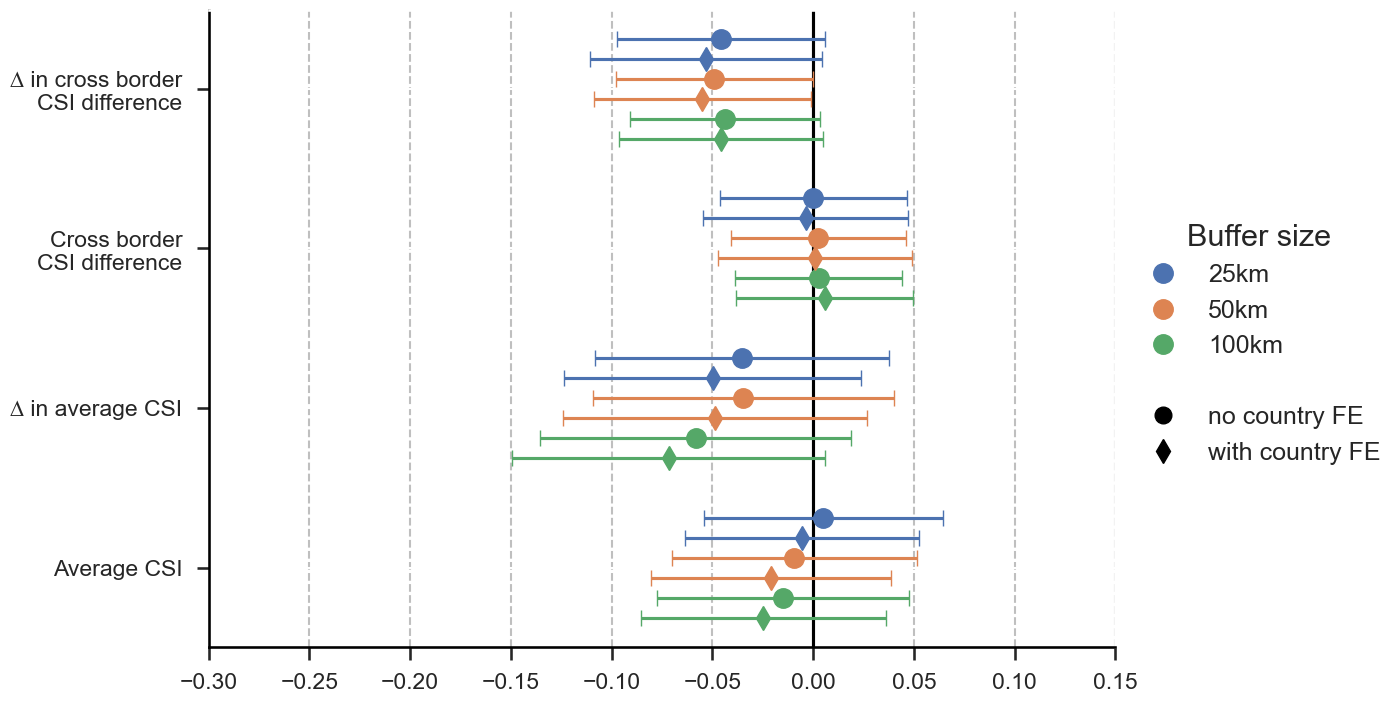

In [31]:
# Code to get the coef figure
# First I need to create the dataframes like this and then need to concatenate them
size_xvars = 4

data = {
    'coeff_name': [],
    'coef': [],
    'model': [],
    'ci_min': [],
    'ci_max': []
}

df = pd.DataFrame(data)

x_vars = ['csi_change_alt','csi_alt','csi_change_oj','csi_oj']
for (est,name) in zip([est25alt, est50alt, est100alt, est25alt_FE, est50alt_FE, est100alt_FE], ['25km', '50km', '100km','25km FE', '50km FE', '100km FE']):
    ci = est.conf_int(alpha=0.05).loc[x_vars]
    data = {
        'coeff_name': x_vars,
        'coef': est.params[x_vars],
        'model': [name] * size_xvars,
        'ci_min': ci.loc[:,0],
        'ci_max': ci.loc[:,1]
    }
    data = pd.DataFrame(data)
    df = pd.concat([df, data], axis=0)

value_map_d = {'csi_change_alt':12.0,'csi_alt':8.0,'csi_change_oj':4.0, 'csi_oj': 0.0}
df['y_vals'] = df['coeff_name'].apply(lambda x: value_map_d.get(x))
model_offset_map = {'25km': 1.25, '25km FE': .75, '50km': 0.25,  '50km FE': -0.25, '100km': -0.75, '100km FE': -1.25}
df['y_vals'] = df['y_vals'] + df['model'].apply(lambda x: model_offset_map.get(x))

df = df.sort_values(by='y_vals', ascending = False).reset_index(drop=True)

# Plot the coef
fig, ax = plt.subplots()
ax.axvline(x=0, color='black')

models = ['25km', '50km', '100km']
for (model,color_point) in zip(models,sns.color_palette(n_colors=len(models))):
    var_df = df[df.model == model]
    ax.errorbar(var_df['coef'], var_df['y_vals'], xerr=[abs(var_df.coef - var_df.ci_min)], linestyle="none", 
                color = color_point, capsize=6, marker = 'o', markersize = 14, label = model)

models = ['25km FE', '50km FE', '100km FE']
for (model,color_point) in zip(models,sns.color_palette(n_colors=len(models))):
    var_df = df[df.model == model]
    ax.errorbar(var_df['coef'], var_df['y_vals'], xerr=[abs(var_df.coef - var_df.ci_min)], linestyle="none", 
                color = color_point, capsize=6, marker = 'd', markersize = 12, label = model)

ax.set_yticks(list(value_map_d.values()))
ax.set_yticklabels(['∆ in cross border\nCSI difference','Cross border\nCSI difference','∆ in average CSI','Average CSI'])

ax.set_xticks(xticks_coef)
ax.set_xticklabels(xlabels_coef)

# modify legend
handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles] # eliminate the error bars and lines from the legend

# add marker types
circle_m = mlines.Line2D([], [], linewidth = 0, color='black', marker='o', markersize=12)
diamond_m = mlines.Line2D([], [], linewidth = 0, color='black', marker='d', markersize=12)
spacer_m = mlines.Line2D([], [], linewidth = 0, color='black', marker="*", markersize=0)

ax.legend(handles[0:3] + [spacer_m, circle_m, diamond_m], labels[0:3] + ['','no country FE','with country FE'], title='Buffer size', title_fontsize = 22, fontsize = 18, 
          bbox_to_anchor=(1, 0.7), framealpha = 0)

# Modify grid and axis lines
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.tick_params(left=True, bottom=True,pad = 10)
ax.set_facecolor('white')
ax.xaxis.grid(c='grey',linestyle = '--', alpha = .5)
plt.savefig( pathgraphs + 'coef_plot_alt_buffers.pdf', dpi=300, bbox_inches='tight')


## Figure B3

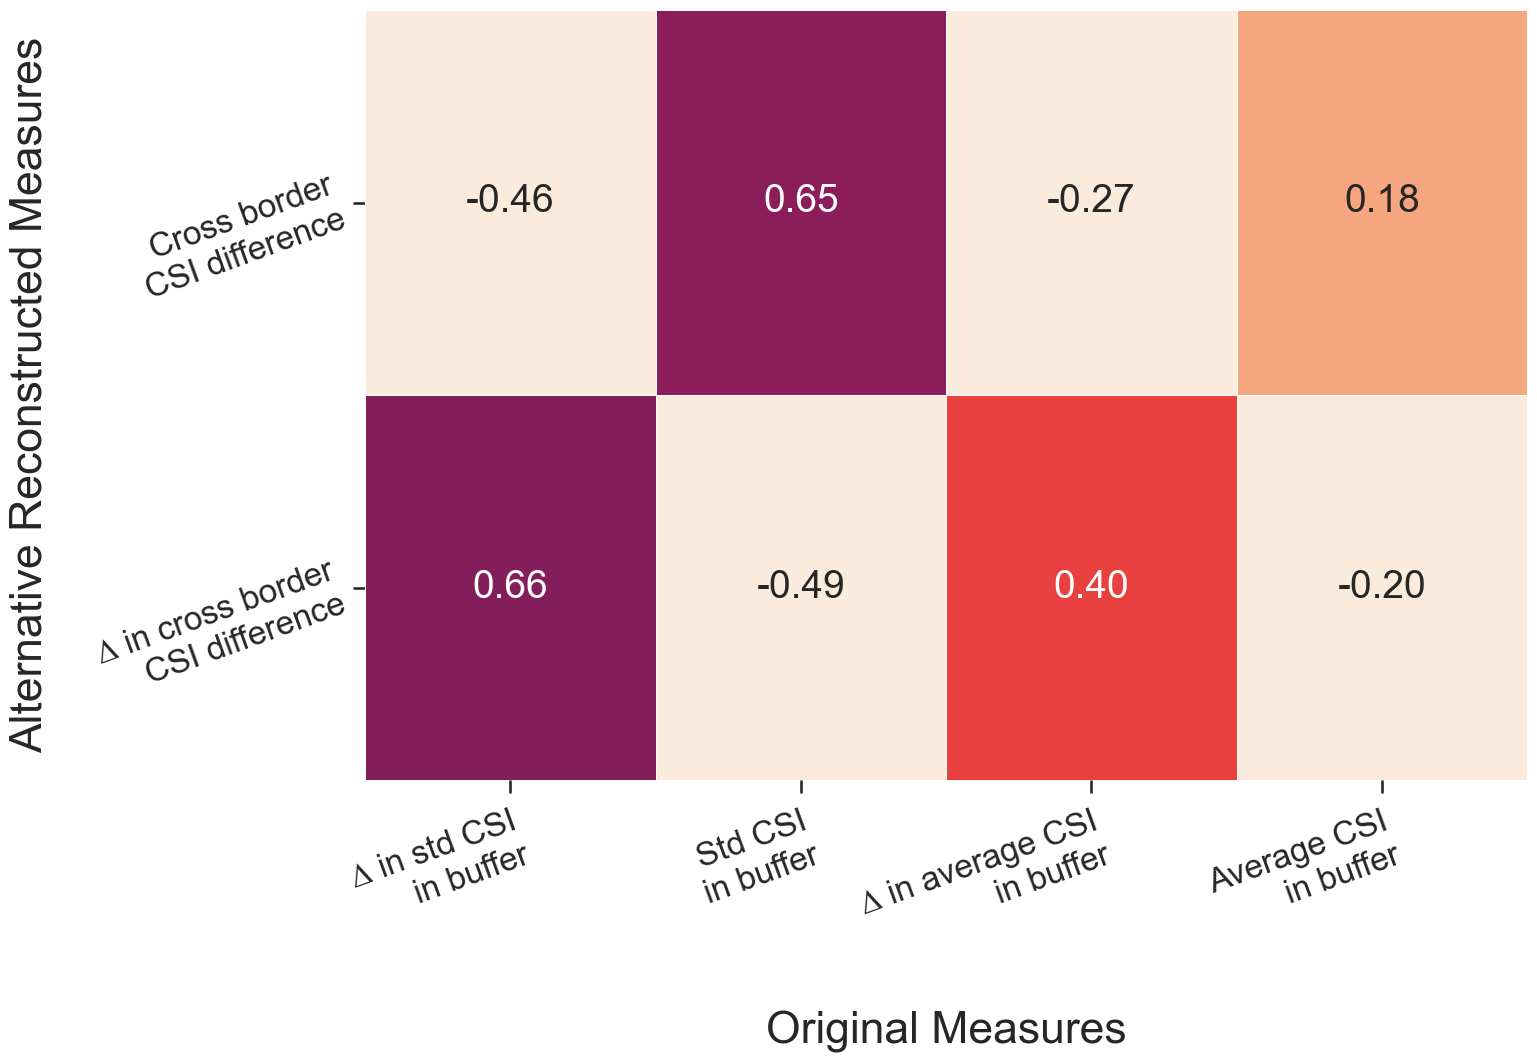

In [32]:
# Reconstructed Buffers for the Ethnologe v16
var1 = ['csi_alt','csi_change_alt']
var2 = ['csi_change_sd','csi_sd','csi_change','csi']

# The code that creates the correlation matrix does a wierd sorting of columns. So we need to reverse the names of the labels

var1_names = reversed(['Average CSI\n in buffer','∆ in average CSI\n in buffer','Std CSI\n in buffer','∆ in std CSI\n in buffer'])
var2_names = ['Cross border\nCSI difference','∆ in cross border\nCSI difference']

myheatmap(dfor17, var1, var2, var1_names, var2_names, "Original Measures", "Alternative Reconstructed Measures", 'heatmap_v17_alt', pad_labels = (-.3, -.27), show = True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2158a300-6955-4725-92f2-79476c32a378' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>